# Data exploration of geoclim and GBS sequencing data from wild coffee tree samples

## About the data
### Source
Hamon P, Grover CE, Davis AP, Rakotomalala JJ, Raharimalala NE, Albert VA, Sreenath HL, Stoffelen P, Mitchell SE, Couturon E, Hamon S, de Kochko A, Crouzillat D, Rigoreau M, Sumirat U, Akaffou S, Guyot R. Genotyping-by-sequencing provides the first well-resolved phylogeny for coffee (Coffea) and insights into the evolution of caffeine content in its species: GBS coffee phylogeny and the evolution of caffeine content. Mol Phylogenet Evol. 2017 Apr;109:351-361. doi: 10.1016/j.ympev.2017.02.009. Epub 2017 Feb 16. PMID: 28212875.

### Metadata
Metadata table in [data directory](coffeaPhyloGeo/data/geoclim/geospatial/coff_madag_species_summary.xlsx)

**Genetic data :**
GBS/Rad-Seq from nuclear DNA. Data cleaning, ref-genome alignement + SNP concat #TODO

**geoclim data :**
GPS positions available in metadata table. To use to extract information on the [Madaclim](https://madaclim.cirad.fr/) database.

---

**All required imports and utils**

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio import plot
from definitions import *
import geopandas as gpd
from shapely.geometry import Point
import calendar
import re
import seaborn as sns
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import colors

## Climate data extraction

### Paths and file configs
See definitions.py for dir paths + config.yaml ref

In [2]:
# File names
print("\n".join([METADATA_RAW, GPS_ALL,GPS_GBS_ONLY, MADACLIM_CURRENT_TIF, ENVIRO_TIF]))

coff_madag_species_summary.xlsx
species_locations_all_positions.csv
species_locations_gbs_only.csv
madaclim_current.tif
madaclim_enviro.tif


### GPS position extraction from metadata + cleaning
Generate 2 csv files for 2 subsets using Pandas :
- all specimens WITH GPS positions (df_gps_all)
- only specimens with BOTH GPS and SNP.fasta (df_gbs_only)

In [3]:
# Read from raw table
df = pd.read_excel(GEOSPATIAL_DIR / METADATA_RAW, decimal=",")
df = df.dropna(how="all")
df.head()

Species            GBS sequence Botanical series  \
0       C.abbayesii        C_abbayesii_A601         Millotii   
1  C.ambodirianenis  C_ambodirianensis_A572         Millotii   
2     C.ambongensis           C_ambongensis       Baracoffea   
3    C.ankaranensis     C_ankaranensis_A525   Multiflorae \n   
4    C.ankaranensis                       -   Multiflorae \n   

  Genome size (2C. pg)     Latitude   Longitude Species code Population code  
0                 1.25     -24.7541     46.8624          ABA            A601  
1                 1.27     -18.4522     48.9433          AMB            A572  
2                 1.16  -15.5745833  46.4198056        AMBON           BR071  
3                 1.17     -12.9491     49.5433         ANK1            A525  
4                 1.17     -12.8491     49.5433         ANK2            A808

**Note for later** Use madaclim to impute missing gps POS on samples : 
- RNF785
- APD3096
- A1013

Let's keep the noposition datapoints to inpute using KNN impute or iterative imputer from SKlearn

In [4]:
# Read from raw table
df = pd.read_excel(GEOSPATIAL_DIR / METADATA_RAW, decimal=",")

# Remove blank lines and strs
df = df.dropna(how="all")
df["GBS sequence"] = df["GBS sequence"].str.rstrip()    #* \n still present after stripping

# Remove \n in Botanical series
df = df.replace(r"\n","", regex=True)

# Converting to proper NaN and reordering
df = df.replace({"-": np.nan, "NO POSITION": np.nan})
df = df[["Species", "Species code", "Population code", "GBS sequence", "Botanical series", "Genome size (2C. pg)", "Latitude", "Longitude"]]
# Remove NO from AND2 species
df["Longitude"] = df["Longitude"].str.replace("NO ", "")
df["Longitude"] = df["Longitude"].str.replace(",", ".").astype(float)

# Removing outgroups and resetting index post cleaning
df = df[df["Botanical series"] != "OUTGROUP"]
df = df.reset_index().drop(columns=["index"])

df


Species Species code Population code  \
0          C.abbayesii          ABA            A601   
1     C.ambodirianenis          AMB            A572   
2        C.ambongensis        AMBON           BR071   
3       C.ankaranensis         ANK1            A525   
4       C.ankaranensis         ANK2            A808   
5         C.arenesiana          ARE            A403   
6         C.augagneuri         AUGA            A966   
7         C.bertrandii         BERT              A5   
8      C.betamponensis          BET            A573   
9          C.bissetiae         BISS           BR031   
10         C.boinensis         BOIN           BR051   
11        C.boiviniana          BOI            A980   
12          C.bonnieri          BON            A535   
13            C.costei          COS            A956   
14         C.coursiana          COU            A570   
15        C.daphnoides          DAP            A317   
16     C.dolichophylla          DOL            A206   
17          C.dubardii          DUB            A969   
18  C.farafanganensis           FAR            A208   
19            C.heimii          HEI            A516   
20          C.homollei          HOM            A945   
21       C.humblotiana         HUMB            A230   
22          C.jumellei          JUM            A974   
23    C.kianjavatensis         KIA2            A602   
24    C.kianjavatensis         KIA1            A213   
25        C.lancifolia          LAN            A320   
26            C.leroyi         AND1            A227   
27            C.leroyi          LER            A315   
28        C.macrocarpa          MAC             MAC   
29      C.mangoroensis         MAN1            A401   
30      C.mangoroensis         MAN2            A402   
31           C.milotti         MIL1            A721   
32           C.milotti         MIL2            A222   
33         C.mogenetti          MOG            A975   
34      C.montis-sacri          MON            A321   
35          C.perrieri         PER1             A12   
36       C.pervilleana         PERV            A957   
37     C.ratsimamangae          RAT            A528   
38          C.resinosa         RES1             A71   
39         C.richardii          RIC            A575   
40     C.sahafaryensis         SAHA            A978   
41         C.sakarahae          SAK            A304   
42         C.tetragona          TET            A252   
43        C.tsirananae          TSI            A515   
44     C.vatovavyensis          VAT            A830   
45          C.vianneyi         VIA1             A20   
46          C.vianneyi         VIA2            A946   
47      C.vohemarensis         VOHE            A977   
48  C_andrambovatensis         AND2            A310   
49         C_humbertii          NaN          RNF785   
50           C_labatii          NaN         APD3096   
51           C_liaudii          NaN           A1013   

                          GBS sequence Botanical series Genome size (2C. pg)  \
0                     C_abbayesii_A601         Millotii                 1.25   
1               C_ambodirianensis_A572         Millotii                 1.27   
2                        C_ambongensis       Baracoffea                 1.16   
3                  C_ankaranensis_A525     Multiflorae                  1.17   
4                                  NaN     Multiflorae                  1.17   
5                    C_arenesiana_A403     Multiflorae                  1.11   
6                    C_augagneuri_A966   Subterminales                  1.18   
7                      C_bertrandii_A5     Multiflorae                  1.22   
8                                  NaN     Multiflorae                  1.26   
9                          C_bissetiae       Baracoffea                 1.19   
10                         C_boinensis       Baracoffea                 1.15   
11                   C_boiviniana_A980   Subterminales                  1.00   
12                     C_bonnieri_A535   Subterminales     

In [5]:
df_gps = df.copy()
print(f"Number of samples for all specimens WITH GPS : {len(df_gps)} (including 3 samples to be imputed)")


Number of samples for all specimens WITH GPS : 52 (including 3 samples to be imputed)


In [6]:
print(f"Number of samples with valid GBS sequence : {len(df.dropna(subset='GBS sequence'))}")

Number of samples with valid GBS sequence : 42


In [7]:
# df_gbs_only = df.copy()
# df_gbs_only.dropna(subset="GBS sequence").reset_index().drop(columns=["index"])
# # df

In [8]:
# Keep df for all species WITH GPS positions and reorder
# df_gps_all = df.copy()
# df_gps_all = df_gps_all.dropna(subset=["Latitude", "Longitude"])
# print(f"Number of samples for all specimens WITH GPS : {len(df_gps_all)}")
# df_gps_all = df_gps_all.reset_index().drop(columns=["index"])

In [9]:
# Clean for missing GBS sequences
# df_gbs_only = df_gps_all.dropna().copy()
# print(f"Number of samples for specimens with BOTH GPS AND genetic data : {len(df_gbs_only)}")
# df_gbs_only = df_gbs_only.reset_index().drop(columns=["index"])

**Save as csv to data/geoclim/geospatial/**

In [10]:
# Save cleaned data to csv in geospatial dir
# df_gps_all.to_csv(GEOSPATIAL_DIR / GPS_ALL, index=False)  # All positions available
# df_gbs_only.to_csv(GEOSPATIAL_DIR / GPS_GBS_ONLY, index=False)    # Species with both gbs AND positions

### Raster file basic manipulations (current climate and enviro data)

In [11]:
# Define ref and checking file state
raster_clim = rasterio.open(CLIMATE_DIR / MADACLIM_CURRENT_TIF)
print(f"File opened ? {not(raster_clim.closed)}")


File opened ? True


In [12]:
raster_enviro = rasterio.open(ENVIRO_DIR / ENVIRO_TIF)
print(f"File opened ? {not(raster_enviro.closed)}")

File opened ? True


In [13]:
# Check for dtypes
if len(set(raster_clim.dtypes)) > 1 :
    print(f"Raster file {MADACLIM_CURRENT_TIF} has more than one dtypes")
    print(set(raster_clim.dtypes))
else:
    print(f"Raster file {MADACLIM_CURRENT_TIF} has only {set(raster_clim.dtypes)}")    

# Get dict for all band dtypes combinations
bands_types = {i: dtype for i, dtype in zip(raster_clim.indexes, raster_clim.dtypes)}
# print(bands_types)

Raster file madaclim_current.tif has only {'int16'}


In [14]:
# Check for dtypes
if len(set(raster_enviro.dtypes)) > 1 :
    print(f"Raster file {MADACLIM_CURRENT_TIF} has more than one dtypes")
    print(set(raster_enviro.dtypes))
else:
    print(f"Raster file {MADACLIM_CURRENT_TIF} has only {set(raster_enviro.dtypes)}")    

# Get dict for all band dtypes combinations
bands_types = {i: dtype for i, dtype in zip(raster_enviro.indexes, raster_enviro.dtypes)}
# print(bands_types)

Raster file madaclim_current.tif has only {'int16'}


In [15]:
# Number of bands total
print(f"{MADACLIM_CURRENT_TIF} has {len(raster_clim.indexes)} bands")
print(f"{ENVIRO_TIF} has {len(raster_enviro.indexes)} bands")

madaclim_current.tif has 70 bands
madaclim_enviro.tif has 9 bands


In [16]:
# Get CRS + bounds
print(f"CRS of {MADACLIM_CURRENT_TIF} : {raster_clim.crs}")
print(f"CRS of {ENVIRO_TIF} : {raster_enviro.crs}")

CRS of madaclim_current.tif : EPSG:32738
CRS of madaclim_enviro.tif : EPSG:32738


In [17]:
# Boundaries of raster
raster_clim.bounds

BoundingBox(left=298000.0, bottom=7155000.0, right=1101000.0, top=8683000.0)

In [18]:
# Example to sample from band1
band1 = raster_clim.read(1)
band1[raster_clim.height // 2, raster_clim.width // 2]

120

In [19]:
#nodata value
print(f"No data value for {MADACLIM_CURRENT_TIF} = {raster_clim.nodata}")
print(f"No data value for {ENVIRO_TIF} = {raster_enviro.nodata}")

No data value for madaclim_current.tif = -32768.0
No data value for madaclim_enviro.tif = -32768.0


Set the same nodata since both identical

In [20]:
nodata_val = raster_clim.nodata

In [21]:
# To read as a numpy array
raster_clim.read(1)

array([[-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       ...,
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768]], dtype=int16)

#### Plotting individual bands and distributions

Example with band 37 = bio1_Mean Annual Temperature

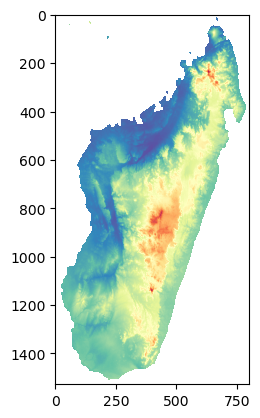

<Axes: >

In [22]:
# bio1_Annual Mean Temp associated with band37 (see example in section below)
rasterio.plot.show(raster_clim.read(37, masked=True), cmap="Spectral")

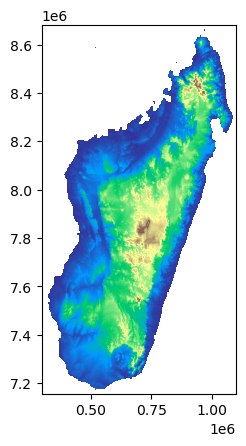

<Axes: >

In [23]:
# Altitude map
rasterio.plot.show(raster_enviro.read(1, masked=True), transform=raster_enviro.transform, cmap="terrain")

Underneat the hood, this is just a masked numpy array that is calling the imshow() method on an axes object.

In [24]:
raster_clim.read(1, masked=True).compressed()[:5]

array([209, 208, 205, 204, 204], dtype=int16)

We could than apply the compressed method to the raster.read(band#) array and plot a more customized version

In [25]:
# For number of dry months
# fig, ax = plt.subplots(figsize=(6,6))
# im = ax.imshow(raster_clim.read(70, masked=True), cmap="inferno", norm="linear")
# cbar = plt.colorbar(im)
# cbar.ax.set_ylabel("Dry months scale")
# plt.title("Number of dry months per year\n", weight="bold")

Again, same for distributions histograms

In [26]:
# # With rasterio
# fig, ax = plt.subplots()

# rasterio.plot.show_hist(
#     raster_clim.read(1, masked=True), bins=50, stacked=False, alpha=0.5,
#     histtype='stepfilled', title="Histogram", label="0", ax=ax,
# )

In [27]:
# With seaborn
# fig, ax = plt.subplots(1, 1, figsize=(6,6))
# sns.histplot(
#     data=raster_clim.read(37, masked=True).compressed(),
#     color="blue",
#     bins=50,
#     ax=ax,
#     kde=True, stat="density",
#     line_kws={"linestyle" : "--"}
# )
# ax.lines[0].set_color("black")
# ax.set_title("Distribution data for band37 (bio1)", pad=10)

Combining both side by side

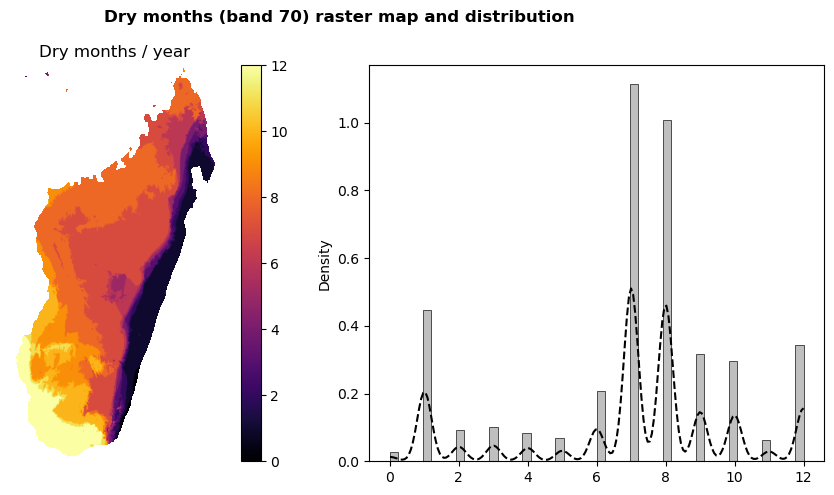

In [28]:
# Selecting the band
band_num = 70
band = raster_clim.read(band_num, masked=True)

# Plotting both map and distributions of raster values
fig, axes = plt.subplots(1, 2, figsize=(10,5))

# Raster map
im = axes[0].imshow(band, cmap="inferno", norm="linear")
cbar = plt.colorbar(im)
axes[0].set_title("Dry months / year")
axes[0].set_yticks([])
axes[0].set_xticks([])
axes[0].axis("off")

# Pixel vals distributions
sns.histplot(
    data=band.compressed(), color="grey", bins=50, ax=axes[1], 
    kde=True, stat="density",
    line_kws={"linestyle" : "--"}
)
axes[1].lines[0].set_color("black")

fig.suptitle("Dry months (band 70) raster map and distribution", weight="bold")
fig.tight_layout()

Same for elevation data with enviro

In [29]:
# With seaborn
# band_num = 1
# fig, ax = plt.subplots(1, 1, figsize=(6,6))
# sns.histplot(
#     data=raster_enviro.read(band_num, masked=True).compressed(),
#     color="blue",
#     bins=50,
#     ax=ax,
#     kde=True, stat="density",
#     line_kws={"linestyle" : "--"}
# )
# ax.lines[0].set_color("black")
# ax.set_title(f"Distribution data for band{band_num} (elevation)", pad=10)

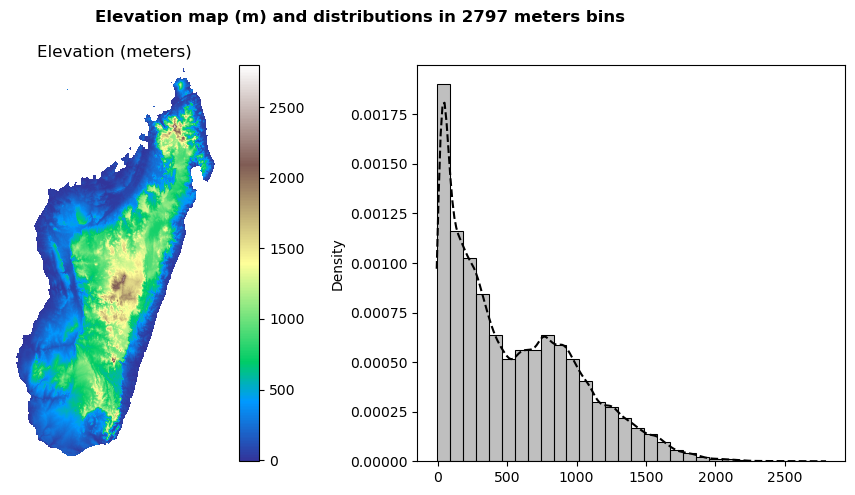

In [30]:
# Selecting the band
band_num = 1
band = raster_enviro.read(band_num, masked=True)

# Plotting both map and distributions of raster values
fig, axes = plt.subplots(1, 2, figsize=(10,5))

# Raster map
im = axes[0].imshow(band, cmap="terrain", norm="linear")
cbar = plt.colorbar(im)
axes[0].set_title("Elevation (meters)")
axes[0].set_yticks([])
axes[0].set_xticks([])
axes[0].axis("off")

# Pixel vals distributions
num_bins = 30
sns.histplot(
    data=band.compressed(), color="grey", bins=num_bins, ax=axes[1], 
    kde=True, stat="density",
    line_kws={"linestyle" : "--"}
)
axes[1].lines[0].set_color("black")

min_elev = np.min(band.compressed())
max_elev = np.max(band.compressed())

fig.suptitle(f"Elevation map (m) and distributions in {np.round((max_elev - min_elev / num_bins)):.0f} meters bins", weight="bold")
fig.tight_layout()

In [31]:
# To acesss masked array data removing nodata
band = raster_enviro.read(1, masked=True).compressed()
band

array([ 5, 13, 14, ..., 45, 28, 12], dtype=int16)

In [32]:
# Get max value
np.max(band)

2797

### Defining the climate variables to get from raster

Get info for bioclim vars

In [33]:
# bioclim vars
def label_bioclim_vars():
    bio1_bio19 = [f"{k}_{v['longname']}" for k,v in config["bioclim_defs"].items()]
    bio_layers = {}
    for i, bio in enumerate(bio1_bio19, start=37):
        bio_layers[f"clim_layer{i}"] = bio
    return bio_layers
label_bioclim_vars ()

{'clim_layer37': 'bio1_Annual Mean Temperature',
 'clim_layer38': 'bio2_Mean Diurnal Range(Mean(period max-min)',
 'clim_layer39': 'bio3_Isothermality (bio2/bio7)',
 'clim_layer40': 'bio4_Temperature Seasonality (C of V)',
 'clim_layer41': 'bio5_Max Temperature of Warmest Period',
 'clim_layer42': 'bio6_Min Temperature of Coldest Period',
 'clim_layer43': 'bio7_Temperature Annual Range (5-6)',
 'clim_layer44': 'bio8_Mean Temperature of Wettest Quarter',
 'clim_layer45': 'bio9_Mean Temperature of Driest Quarter',
 'clim_layer46': 'bio10_Mean Temperature of Warmest Quarter',
 'clim_layer47': 'bio11_Mean Temperature of Coldest Quarter',
 'clim_layer48': 'bio12_Annual Precipitation',
 'clim_layer49': 'bio13_Precipitation of Wettest Period',
 'clim_layer50': 'bio14_Precipitation of Driest Period',
 'clim_layer51': 'bio15_Precipitation Seasonality(C of V)',
 'clim_layer52': 'bio16_Precipitation of Wettest Quarter',
 'clim_layer53': 'bio17_Precipitation of Driest Quarter',
 'clim_layer54': 'b

Get info for monthly vars

In [34]:
# Layers description for monthly vars
l1_12 = "Monthly minimum temperature (C x 10)"
l13_24 = "Monthly maximum temperature (C x 10)"
l25_36 = "Monthly total precipitation (mm.month-1)"
l56_67 = "Monthly potential evapotranspiration (mm.month-1)"

In [35]:
def label_monthly_vars(description, first_layer):
    layers = {}
    monthly_vars = [f"{description}_{month}" for month in calendar.month_name[1:]]
    for i, month in enumerate(monthly_vars, start=first_layer):
        layers[f"clim_layer{i}"] = month
    return layers

Get info for annual vars

In [36]:
l68 = {"clim_layer68" : "Annual potential evapotranspiration (mm)"}
l69 = {"clim_layer69" : "Annual climatic water deficit (mm)"}
l70 = {"clim_layer70" : "Number of dry months in the year"}

Generate all vars dictionary

In [37]:
# Layers 1 to 12
mada_layers = {}
temp_layers = label_monthly_vars(l1_12, 1)
mada_layers.update(temp_layers)

# Layers 13 to 24
temp_layers = label_monthly_vars(l13_24, 13)
mada_layers.update(temp_layers)

# Layers 25 to 36
temp_layers = label_monthly_vars(l25_36, 25)
mada_layers.update(temp_layers)

# Layers 37 to 55 (bioclim)
temp_layers = label_bioclim_vars()
mada_layers.update(temp_layers)

# Layers 56 to 67
temp_layers = label_monthly_vars(l56_67, 56)
mada_layers.update(temp_layers)
mada_layers.update(l68)
mada_layers.update(l69)
mada_layers.update(l70)

mada_layers

{'clim_layer1': 'Monthly minimum temperature (C x 10)_January',
 'clim_layer2': 'Monthly minimum temperature (C x 10)_February',
 'clim_layer3': 'Monthly minimum temperature (C x 10)_March',
 'clim_layer4': 'Monthly minimum temperature (C x 10)_April',
 'clim_layer5': 'Monthly minimum temperature (C x 10)_May',
 'clim_layer6': 'Monthly minimum temperature (C x 10)_June',
 'clim_layer7': 'Monthly minimum temperature (C x 10)_July',
 'clim_layer8': 'Monthly minimum temperature (C x 10)_August',
 'clim_layer9': 'Monthly minimum temperature (C x 10)_September',
 'clim_layer10': 'Monthly minimum temperature (C x 10)_October',
 'clim_layer11': 'Monthly minimum temperature (C x 10)_November',
 'clim_layer12': 'Monthly minimum temperature (C x 10)_December',
 'clim_layer13': 'Monthly maximum temperature (C x 10)_January',
 'clim_layer14': 'Monthly maximum temperature (C x 10)_February',
 'clim_layer15': 'Monthly maximum temperature (C x 10)_March',
 'clim_layer16': 'Monthly maximum temperature

In [38]:
len(mada_layers)

70

In [39]:
# Add envi layers to mada_layers db
env_vars = ['Altitude (m)', 'Slope (in degree)', 'Aspect (clockwise from North, in degree)', 'Solar radiation (Wh.m-2.day-1)', 'Geology (Kew Botanical Garden, 1997)', 'Soil (Pelletier, 1981)', 'Vegetation (Kew Botanical Garden, 2007)', 'Watersheds (Pearson, 2009)', 'Percentage of forest cover for the year 2010 (%).']
env_layers = {}
for i, layer in enumerate(env_vars, start=1):
    env_layers[f"env_layer{i}"] = layer
env_layers

{'env_layer1': 'Altitude (m)',
 'env_layer2': 'Slope (in degree)',
 'env_layer3': 'Aspect (clockwise from North, in degree)',
 'env_layer4': 'Solar radiation (Wh.m-2.day-1)',
 'env_layer5': 'Geology (Kew Botanical Garden, 1997)',
 'env_layer6': 'Soil (Pelletier, 1981)',
 'env_layer7': 'Vegetation (Kew Botanical Garden, 2007)',
 'env_layer8': 'Watersheds (Pearson, 2009)',
 'env_layer9': 'Percentage of forest cover for the year 2010 (%).'}

In [40]:
mada_layers.update(env_layers)
mada_layers

{'clim_layer1': 'Monthly minimum temperature (C x 10)_January',
 'clim_layer2': 'Monthly minimum temperature (C x 10)_February',
 'clim_layer3': 'Monthly minimum temperature (C x 10)_March',
 'clim_layer4': 'Monthly minimum temperature (C x 10)_April',
 'clim_layer5': 'Monthly minimum temperature (C x 10)_May',
 'clim_layer6': 'Monthly minimum temperature (C x 10)_June',
 'clim_layer7': 'Monthly minimum temperature (C x 10)_July',
 'clim_layer8': 'Monthly minimum temperature (C x 10)_August',
 'clim_layer9': 'Monthly minimum temperature (C x 10)_September',
 'clim_layer10': 'Monthly minimum temperature (C x 10)_October',
 'clim_layer11': 'Monthly minimum temperature (C x 10)_November',
 'clim_layer12': 'Monthly minimum temperature (C x 10)_December',
 'clim_layer13': 'Monthly maximum temperature (C x 10)_January',
 'clim_layer14': 'Monthly maximum temperature (C x 10)_February',
 'clim_layer15': 'Monthly maximum temperature (C x 10)_March',
 'clim_layer16': 'Monthly maximum temperature

Example to find layer# of Mean Annual temperature

In [41]:
for k,v in mada_layers.items():
    if re.search("[Aa]nnual Mean", mada_layers[k]):
        print(k, v)

clim_layer37 bio1_Annual Mean Temperature


In [42]:
#TODO ENCAPSULATE MADA_LAYERS IN A CLASS WITH CLIM AND ENVIRO ATTRIBUTES + METHODS

### Creating Point objects for each specimen

Checking for similar crs proj between the 2 rasters

OK for this project, if not we can create multiple geometries within a single df and "activate" each one when required. See this github gist : https://gist.github.com/maptastik/0f657b86d7b893c5d7130e487f80d486

In [43]:
print(f"df_gps has {len(df_gps)} specimens (including {df_gps[['Latitude', 'Longitude']].isna().sum().unique()[0]} NaN)")
# df_gbs = df_gbs.set_index("Species code")
# df_gbs.head()
if raster_enviro.crs == raster_clim.crs:
    print(f"{MADACLIM_CURRENT_TIF} (crs={raster_clim.crs}) and {ENVIRO_TIF} (crs={raster_enviro.crs} share the same projection")
else : 
    print(f"{MADACLIM_CURRENT_TIF} (crs={raster_clim.crs}) and {ENVIRO_TIF} (crs={raster_enviro.crs} do not share the same projection")
    print("More work will have to be done to incorporate both. We could just create 2 separate geodf and merge them in the end.")

df_gps has 52 specimens (including 3 NaN)
madaclim_current.tif (crs=EPSG:32738) and madaclim_enviro.tif (crs=EPSG:32738 share the same projection


Create shapely.Point objects from GPS coordinates

In [44]:
# Beware of lon/lat order in instance creation
points = [Point(float(row[1]["Longitude"]), float(row[1]["Latitude"])) for row in df_gps.iterrows()]
points[0:5]

[<POINT (46.862 -24.754)>,
 <POINT (48.943 -18.452)>,
 <POINT (46.42 -15.575)>,
 <POINT (49.543 -12.949)>,
 <POINT (49.543 -12.849)>]

Create GeoPandas dataframe with original gps projection for specimens

In [45]:
# Original coordinates under GPS format aka epsg:4326
gdf = gpd.GeoDataFrame(df_gps, geometry=points, crs=4326)
gdf.head()

Species Species code Population code            GBS sequence  \
0       C.abbayesii          ABA            A601        C_abbayesii_A601   
1  C.ambodirianenis          AMB            A572  C_ambodirianensis_A572   
2     C.ambongensis        AMBON           BR071           C_ambongensis   
3    C.ankaranensis         ANK1            A525     C_ankaranensis_A525   
4    C.ankaranensis         ANK2            A808                     NaN   

  Botanical series Genome size (2C. pg)     Latitude  Longitude  \
0         Millotii                 1.25     -24.7541  46.862400   
1         Millotii                 1.27     -18.4522  48.943300   
2       Baracoffea                 1.16  -15.5745833  46.419806   
3     Multiflorae                  1.17     -12.9491  49.543300   
4     Multiflorae                  1.17     -12.8491  49.543300   

                     geometry  
0  POINT (46.86240 -24.75410)  
1  POINT (48.94330 -18.45220)  
2  POINT (46.41981 -15.57458)  
3  POINT (49.54330 -12.94910)  
4  POINT (49.54330 -12.84910)

In [46]:
# to get the x/lon attribute of Point objects
gdf["geometry"].x.head()  #lon


0    46.862400
1    48.943300
2    46.419806
3    49.543300
4    49.543300
dtype: float64

Check CRS + transform to Madaclim_current.tif raster CRS

In [47]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [48]:
if gdf.crs != raster_clim.crs and gdf.crs != raster_enviro.crs:
    print(f"gdf proj ({gdf.crs}) not corresponding to both raster files crs. We need to reproject the geometry of the gdf")
    gdf = gdf.to_crs(raster_clim.crs)

gdf proj (EPSG:4326) not corresponding to both raster files crs. We need to reproject the geometry of the gdf


In [49]:
gdf.head()

Species Species code Population code            GBS sequence  \
0       C.abbayesii          ABA            A601        C_abbayesii_A601   
1  C.ambodirianenis          AMB            A572  C_ambodirianensis_A572   
2     C.ambongensis        AMBON           BR071           C_ambongensis   
3    C.ankaranensis         ANK1            A525     C_ankaranensis_A525   
4    C.ankaranensis         ANK2            A808                     NaN   

  Botanical series Genome size (2C. pg)     Latitude  Longitude  \
0         Millotii                 1.25     -24.7541  46.862400   
1         Millotii                 1.27     -18.4522  48.943300   
2       Baracoffea                 1.16  -15.5745833  46.419806   
3     Multiflorae                  1.17     -12.9491  49.543300   
4     Multiflorae                  1.17     -12.8491  49.543300   

                         geometry  
0  POINT (688328.240 7260998.023)  
1  POINT (916635.952 7955240.629)  
2  POINT (652237.905 8277614.406)  
3  POINT (993250.150 8564104.062)  
4  POINT (993446.882 8575194.181)

View points on raster map

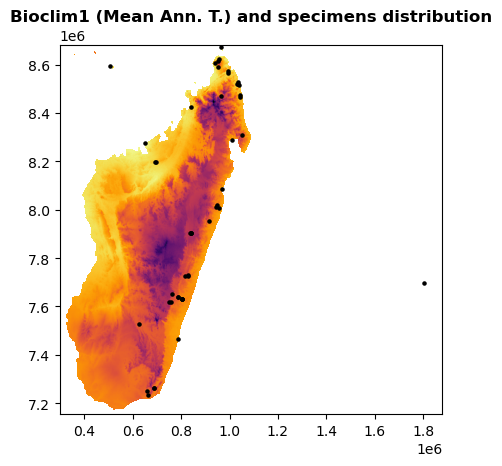

In [50]:
# Plotting with matplotlib.pyplot, rasterio.show and GeoPandas.plot modules
with rasterio.open(CLIMATE_DIR / MADACLIM_CURRENT_TIF) as raster_clim:

    fig, ax = plt.subplots()
    ax = rasterio.plot.show(raster_clim.read(1, masked=True), transform=raster_clim.transform, cmap="inferno", ax=ax, title="Bioclim1 (Mean Ann. T.) and specimens distribution")
    # cbar = plt.colorbar(im)
    # cbar.ax.set_ylabel("bio1_Annual Mean Temperature")
    # plt.title("Bioclim1 and species distribution", weight="bold")
    # ax.set_aspect("equal")
    gdf.plot(ax=ax, color="black", markersize=5)


In [51]:
gdf

Species Species code Population code  \
0          C.abbayesii          ABA            A601   
1     C.ambodirianenis          AMB            A572   
2        C.ambongensis        AMBON           BR071   
3       C.ankaranensis         ANK1            A525   
4       C.ankaranensis         ANK2            A808   
5         C.arenesiana          ARE            A403   
6         C.augagneuri         AUGA            A966   
7         C.bertrandii         BERT              A5   
8      C.betamponensis          BET            A573   
9          C.bissetiae         BISS           BR031   
10         C.boinensis         BOIN           BR051   
11        C.boiviniana          BOI            A980   
12          C.bonnieri          BON            A535   
13            C.costei          COS            A956   
14         C.coursiana          COU            A570   
15        C.daphnoides          DAP            A317   
16     C.dolichophylla          DOL            A206   
17          C.dubardii          DUB            A969   
18  C.farafanganensis           FAR            A208   
19            C.heimii          HEI            A516   
20          C.homollei          HOM            A945   
21       C.humblotiana         HUMB            A230   
22          C.jumellei          JUM            A974   
23    C.kianjavatensis         KIA2            A602   
24    C.kianjavatensis         KIA1            A213   
25        C.lancifolia          LAN            A320   
26            C.leroyi         AND1            A227   
27            C.leroyi          LER            A315   
28        C.macrocarpa          MAC             MAC   
29      C.mangoroensis         MAN1            A401   
30      C.mangoroensis         MAN2            A402   
31           C.milotti         MIL1            A721   
32           C.milotti         MIL2            A222   
33         C.mogenetti          MOG            A975   
34      C.montis-sacri          MON            A321   
35          C.perrieri         PER1             A12   
36       C.pervilleana         PERV            A957   
37     C.ratsimamangae          RAT            A528   
38          C.resinosa         RES1             A71   
39         C.richardii          RIC            A575   
40     C.sahafaryensis         SAHA            A978   
41         C.sakarahae          SAK            A304   
42         C.tetragona          TET            A252   
43        C.tsirananae          TSI            A515   
44     C.vatovavyensis          VAT            A830   
45          C.vianneyi         VIA1             A20   
46          C.vianneyi         VIA2            A946   
47      C.vohemarensis         VOHE            A977   
48  C_andrambovatensis         AND2            A310   
49         C_humbertii          NaN          RNF785   
50           C_labatii          NaN         APD3096   
51           C_liaudii          NaN           A1013   

                          GBS sequence Botanical series Genome size (2C. pg)  \
0                     C_abbayesii_A601         Millotii                 1.25   
1               C_ambodirianensis_A572         Millotii                 1.27   
2                        C_ambongensis       Baracoffea                 1.16   
3                  C_ankaranensis_A525     Multiflorae                  1.17   
4                                  NaN     Multiflorae                  1.17   
5                    C_arenesiana_A403     Multiflorae                  1.11   
6                    C_augagneuri_A966   Subterminales                  1.18   
7                      C_bertrandii_A5     Multiflorae                  1.22   
8                                  NaN     Multiflorae                  1.26   
9                          C_bissetiae       Baracoffea                 1.19   
10                         C_boinensis       Baracoffea                 1.15   
11                   C_boiviniana_A980   Subterminales                  1.00   
12                     C_bonnieri_A535   Subterminales     

In [52]:
# To check certain point on map
gdf.iloc[28:29,:]

Species Species code Population code      GBS sequence  \
28  C.macrocarpa          MAC             MAC  C_macrocarpa-pet   

   Botanical series Genome size (2C. pg) Latitude  Longitude  \
28              Mau                 1.17  -20.378      57.43   

                           geometry  
28  POINT (1804918.843 7696851.850)

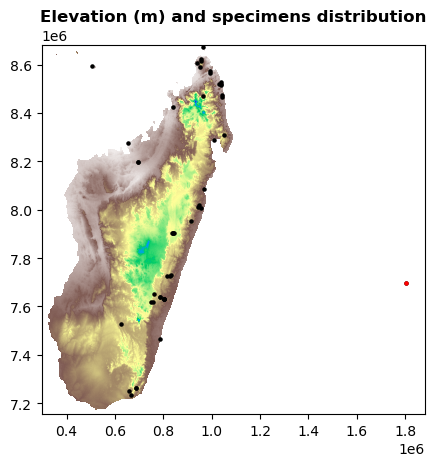

In [53]:
# Plotting with matplotlib.pyplot, rasterio.show and GeoPandas.plot modules
with rasterio.open(CLIMATE_DIR / MADACLIM_CURRENT_TIF) as raster_enviro:

    fig, ax = plt.subplots()
    ax = rasterio.plot.show(raster_enviro.read(1, masked=True), transform=raster_enviro.transform, cmap="terrain", ax=ax, title="Elevation (m) and specimens distribution")
    # cbar = plt.colorbar(im)
    # cbar.ax.set_ylabel("bio1_Annual Mean Temperature")
    # plt.title("Bioclim1 and species distribution", weight="bold")
    # ax.set_aspect("equal")
    gdf.plot(ax=ax, color="black", markersize=5)
    gdf.iloc[28:29,:].plot(ax=ax, color="red", markersize=5)

OK nice it works, we can improve visualization later. Still we see some outlier points that won't have any data (outgroups + others)

### Using GeoPandas with Rasterio to sample point data

#### Prep data for multivariate imputation

In [54]:
# To replace based on condition
# gdf["geometry"].loc[gdf["geometry"].is_empty] = Point(50, 50)

In [55]:
from shapely import Point

# Save unknown in separate dataframe
gdf_unknowns = gdf.loc[gdf["geometry"].is_empty]
gdf_unknowns.head()

Species Species code Population code        GBS sequence  \
49  C_humbertii          NaN          RNF785  C_humbertii_RNF785   
50    C_labatii          NaN         APD3096   C_labatii_APD3096   
51    C_liaudii          NaN           A1013     C_liaudii_A1013   

   Botanical series Genome size (2C. pg) Latitude  Longitude     geometry  
49              NaN                  NaN      NaN        NaN  POINT EMPTY  
50              NaN                  NaN      NaN        NaN  POINT EMPTY  
51              NaN                  NaN      NaN        NaN  POINT EMPTY

In [57]:
gdf_knowns = gdf[gdf["geometry"].is_empty == False]
gdf_knowns.head()

Species Species code Population code            GBS sequence  \
0       C.abbayesii          ABA            A601        C_abbayesii_A601   
1  C.ambodirianenis          AMB            A572  C_ambodirianensis_A572   
2     C.ambongensis        AMBON           BR071           C_ambongensis   
3    C.ankaranensis         ANK1            A525     C_ankaranensis_A525   
4    C.ankaranensis         ANK2            A808                     NaN   

  Botanical series Genome size (2C. pg)     Latitude  Longitude  \
0         Millotii                 1.25     -24.7541  46.862400   
1         Millotii                 1.27     -18.4522  48.943300   
2       Baracoffea                 1.16  -15.5745833  46.419806   
3     Multiflorae                  1.17     -12.9491  49.543300   
4     Multiflorae                  1.17     -12.8491  49.543300   

                         geometry  
0  POINT (688328.240 7260998.023)  
1  POINT (916635.952 7955240.629)  
2  POINT (652237.905 8277614.406)  
3  POINT (993250.150 8564104.062)  
4  POINT (993446.882 8575194.181)

In [59]:
test_gdf = gdf_knowns.copy()

**Extract for all coords + create cols on geodf**

In [78]:
# function to sample all datapoints from the raster map
def sample_from_raster(gdf, geom_column_name, raster_clim_file, raster_env_file, mada_layers):
    raster_clim = rasterio.open(CLIMATE_DIR / raster_clim_file)
    raster_enviro = rasterio.open(ENVIRO_DIR / raster_env_file)
    
    # Geom points coordinates from geometry of gdf
    coord_list = [(x,y) for x,y in zip(gdf[geom_column_name].x, gdf[geom_column_name].y)]
    
    # Sample rasters from Points (specimens coord)
    all_vals_clim = [x for x in raster_clim.sample(coord_list)]
    print(f"Num specimens extracted from {MADACLIM_CURRENT_TIF} : {len(all_vals_clim)}")
    all_vals_env = [x for x in raster_enviro.sample(coord_list)]
    print(f"Num specimens extracted from {ENVIRO_TIF} : {len(all_vals_env)}\n")
    
    # Get specimens with no data
    num_nodata_clim = sum([nodata_val in val for val in all_vals_clim])
    if num_nodata_clim > 0 :
        print(f"Number of specimens containing 'nodata' values when extracting from {raster_clim_file} = {num_nodata_clim}")
        print(f"List of specimen index with at least 1 no data point : {[i for i, val in enumerate(all_vals_clim) if nodata_val in val]}\n")
    else:
        print(f"No specimen containing nodata values in any of the {len(all_vals_clim)} variables from {raster_clim_file}\n")
    
    num_nodata_env = sum([nodata_val in val for val in all_vals_env])
    if num_nodata_env > 0 :
        print(f"Number of specimens containing 'nodata' values when extracting from {raster_env_file} = {num_nodata_env}")
        print(f"List of specimen index with at least 1 no data point : {[i for i, val in enumerate(all_vals_env) if nodata_val in val]}\n")
    else:
        print(f"No specimen containing nodata values in any of the {len(all_vals_env)} variables from {raster_env_file}\n")
    
    # Assign a col for each sampled values
    gdf["all_vals_clim"] = all_vals_clim
    gdf["all_vals_env"] = all_vals_env
    
    temp_dict = {k:v for k,v in mada_layers.items() if k.startswith("clim")}    # Clim layers only
    for index, (k, v) in enumerate(temp_dict.items()):
        for val, specimen_index in zip(all_vals_clim, gdf.index.to_list()):
            gdf.loc[specimen_index, f"{k} : {v}"] = val[index]
    
    temp_dict = {k:v for k,v in mada_layers.items() if k.startswith("env")}    # Env layers only
    for index, (k, v) in enumerate(temp_dict.items()):
        for val, specimen_index in zip(all_vals_env, gdf.index.to_list()):
            gdf.loc[specimen_index, f"{k} : {v}"] = val[index]


    raster_clim.close()
    raster_enviro.close()
    return gdf, all_vals_clim, all_vals_env
    
    
gdf_knowns, all_vals_clim, all_vals_env  = sample_from_raster(gdf_knowns, "geometry", MADACLIM_CURRENT_TIF, ENVIRO_TIF, mada_layers)



Num specimens extracted from madaclim_current.tif : 49
Num specimens extracted from madaclim_enviro.tif : 49

Number of specimens containing 'nodata' values when extracting from madaclim_current.tif = 2
List of specimen index with at least 1 no data point : [28, 38]

Number of specimens containing 'nodata' values when extracting from madaclim_enviro.tif = 5
List of specimen index with at least 1 no data point : [2, 21, 28, 38, 40]



/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/geopandas/geodataframe.py:1443:

Verification for correct values sampled

In [76]:
all_vals_clim[0:5]

[array([ 155,  195,  188,  171,  136,  122,  120,  124,  138,  173,  188,
         196,  276,  295,  288,  281,  266,  243,  235,  240,  259,  286,
         293,  297,   57,  181,  169,   73,   64,   73,   58,   57,   44,
         105,  175,  204,  215,  112,   63, 2597,  297,  120,  177,  238,
         186,  238,  180, 1260,  204,   44,   56,  484,  159,  484,  188,
          92,  125,  113,   94,   67,   50,   44,   47,   60,   92,  110,
         123, 1022,   77,    4], dtype=int16),
 array([ 157,  203,  199,  185,  164,  149,  142,  139,  144,  179,  194,
         203,  263,  291,  290,  278,  269,  248,  221,  226,  240,  281,
         288,  291,   67,  367,  398,  176,  119,  141,  136,  121,   79,
         140,  254,  347,  218,   94,   61, 2513,  291,  139,  152,  241,
         185,  241,  185, 2345,  398,   67,   59,  941,  336,  941,  336,
          83,  123,  117,   98,   80,   61,   47,   48,   56,   92,  109,
         121, 1041,   16,    1], dtype=int16),
 array([ 222,  236

In [82]:
gdf_knowns.iloc[:, 8:18].head()

geometry  \
0  POINT (688328.240 7260998.023)   
1  POINT (916635.952 7955240.629)   
2  POINT (652237.905 8277614.406)   
3  POINT (993250.150 8564104.062)   
4  POINT (993446.882 8575194.181)   

                                       all_vals_clim  \
0  [155, 195, 188, 171, 136, 122, 120, 124, 138, ...   
1  [157, 203, 199, 185, 164, 149, 142, 139, 144, ...   
2  [222, 236, 238, 235, 217, 199, 191, 193, 205, ...   
3  [206, 228, 227, 224, 211, 192, 186, 188, 194, ...   
4  [203, 226, 224, 222, 209, 190, 184, 186, 192, ...   

                              all_vals_env  \
0  [350, 14, 167, 6475, 10, 9, 14, 5, 100]   
1    [567, 8, 27, 7894, 10, 11, 14, 2, 65]   
2  [24, 1, 304, 7784, 1, -32768, 5, 9, 44]   
3     [158, 12, 42, 7979, 6, 18, 7, 1, 20]   
4       [137, 6, 355, 8056, 7, 6, 7, 1, 0]   

   clim_layer1 : Monthly minimum temperature (C x 10)_January  \
0                                              155.0            
1                                              157.0            
2                                              222.0            
3                                              206.0            
4                                              203.0            

   clim_layer2 : Monthly minimum temperature (C x 10)_February  \
0                                              195.0             
1                                              203.0             
2                                              236.0             
3                                              228.0             
4                                              226.0             

   clim_layer3 : Monthly minimum temperature (C x 10)_March  \
0                                              188.0          
1                                              199.0          
2                                              238.0          
3                                              227.0          
4                                              224.0          

   clim_layer4 : Monthly minimum temperature (C x 10)_April  \
0                                              171.0          
1                                              185.0          
2                                              235.0          
3                                              224.0          
4                                              222.0          

   clim_layer5 : Monthly minimum temperature (C x 10)_May  \
0                                              136.0        
1                                              164.0        
2                                              217.0        
3                                              211.0        
4                                              209.0        

   clim_layer6 : Monthly minimum temperature (C x 10)_June  \
0                                              122.0         
1                                              149.0         
2                                              199.0         
3                                              192.0         
4                                              190.0         

   clim_layer7 : Monthly minimum temperature (C x 10)_July  
0                                              120.0        
1                                              142.0        
2                                              191.0        
3                                              186.0        
4                                              184.0

In [83]:
all_vals_env[0:5]

[array([ 350,   14,  167, 6475,   10,    9,   14,    5,  100], dtype=int16),
 array([ 567,    8,   27, 7894,   10,   11,   14,    2,   65], dtype=int16),
 array([    24,      1,    304,   7784,      1, -32768,      5,      9,
            44], dtype=int16),
 array([ 158,   12,   42, 7979,    6,   18,    7,    1,   20], dtype=int16),
 array([ 137,    6,  355, 8056,    7,    6,    7,    1,    0], dtype=int16)]

In [85]:
gdf_knowns.iloc[:, 80:91].head()

clim_layer70 : Number of dry months in the year  env_layer1 : Altitude (m)  \
0                                              4.0                      350.0   
1                                              1.0                      567.0   
2                                              8.0                       24.0   
3                                              8.0                      158.0   
4                                              8.0                      137.0   

   env_layer2 : Slope (in degree)  \
0                            14.0   
1                             8.0   
2                             1.0   
3                            12.0   
4                             6.0   

   env_layer3 : Aspect (clockwise from North, in degree)  \
0                                              167.0       
1                                               27.0       
2                                              304.0       
3                                               42.0       
4                                              355.0       

   env_layer4 : Solar radiation (Wh.m-2.day-1)  \
0                                       6475.0   
1                                       7894.0   
2                                       7784.0   
3                                       7979.0   
4                                       8056.0   

   env_layer5 : Geology (Kew Botanical Garden, 1997)  \
0                                               10.0   
1                                               10.0   
2                                                1.0   
3                                                6.0   
4                                                7.0   

   env_layer6 : Soil (Pelletier, 1981)  \
0                                  9.0   
1                                 11.0   
2                             -32768.0   
3                                 18.0   
4                                  6.0   

   env_layer7 : Vegetation (Kew Botanical Garden, 2007)  \
0                                               14.0      
1                                               14.0      
2                                                5.0      
3                                                7.0      
4                                                7.0      

   env_layer8 : Watersheds (Pearson, 2009)  \
0                                      5.0   
1                                      2.0   
2                                      9.0   
3                                      1.0   
4                                      1.0   

   env_layer9 : Percentage of forest cover for the year 2010 (%).  
0                                              100.0               
1                                               65.0               
2                                               44.0               
3                                               20.0               
4                                                0.0

In [86]:
gdf_knowns.shape

(49, 90)

### Evaluating and replacing missing data in specimen fashion and per feature

**Check all the nodata values (-32768.0) specimens and filter/recover when possible**

In [109]:
# Get col names of layers only
features = gdf_knowns.columns[11:].to_list()

In [161]:
# Features with number of datapoints with nodata
nodata_features = (gdf_knowns[features] == nodata_val).sum()

In [164]:
for i in range(max(nodata_features) + 1):
    print(f"Number of datapoints = {nodata_val} present  in > {i} feature(s)")
    print(nodata_features[(nodata_features > i)].sum())

Number of datapoints = -32768.0 prensent  in > 0 feature(s)
164
Number of datapoints = -32768.0 prensent  in > 1 feature(s)
164
Number of datapoints = -32768.0 prensent  in > 2 feature(s)
14
Number of datapoints = -32768.0 prensent  in > 3 feature(s)
8
Number of datapoints = -32768.0 prensent  in > 4 feature(s)
0


In [165]:
for i in range(max(nodata_features) + 1):
    print(f"Number of datapoints = {nodata_val} present  in = {i} feature(s)")
    print(nodata_features[(nodata_features == i)].sum())

Number of datapoints = -32768.0 prensent  in = 0 feature(s)
0
Number of datapoints = -32768.0 prensent  in = 1 feature(s)
0
Number of datapoints = -32768.0 prensent  in = 2 feature(s)
150
Number of datapoints = -32768.0 prensent  in = 3 feature(s)
6
Number of datapoints = -32768.0 prensent  in = 4 feature(s)
8


In [212]:
# Top features with nodata other than 2 problematic specimens
print(nodata_features[(nodata_features > 2)])

env_layer5 : Geology (Kew Botanical Garden, 1997)                 4
env_layer6 : Soil (Pelletier, 1981)                               4
env_layer8 : Watersheds (Pearson, 2009)                           3
env_layer9 : Percentage of forest cover for the year 2010 (%).    3
dtype: int64


2 Specimens have most of their data as nodata values

In [207]:
mostly_nodata_specimens = gdf_knowns[(gdf_knowns.iloc[:, 11:] == nodata_val).sum(axis=1) > len(mada_layers) - 2]

In [208]:
mostly_nodata_specimens

Species Species code Population code      GBS sequence  \
28  C.macrocarpa          MAC             MAC  C_macrocarpa-pet   
38    C.resinosa         RES1             A71     C_resinosa_A8   

   Botanical series Genome size (2C. pg) Latitude  Longitude  \
28              Mau                 1.17  -20.378    57.4300   
38     Multiflorae                  1.27   -15.45    49.7333   

                           geometry  \
28  POINT (1804918.843 7696851.850)   
38  POINT (1008284.884 8286298.730)   

                                        all_vals_clim  ...  \
28  [-32768, -32768, -32768, -32768, -32768, -3276...  ...   
38  [-32768, -32768, -32768, -32768, -32768, -3276...  ...   

   clim_layer70 : Number of dry months in the year  env_layer1 : Altitude (m)  \
28                                        -32768.0                   -32768.0   
38                                        -32768.0                   -32768.0   

    env_layer2 : Slope (in degree)  \
28                        -32768.0   
38                        -32768.0   

    env_layer3 : Aspect (clockwise from North, in degree)  \
28                                           -32768.0       
38                                           -32768.0       

    env_layer4 : Solar radiation (Wh.m-2.day-1)  \
28                                     -32768.0   
38                                     -32768.0   

    env_layer5 : Geology (Kew Botanical Garden, 1997)  \
28                                           -32768.0   
38                                           -32768.0   

    env_layer6 : Soil (Pelletier, 1981)  \
28                             -32768.0   
38                             -32768.0   

    env_layer7 : Vegetation (Kew Botanical Garden, 2007)  \
28                                           -32768.0      
38                                               25.0      

    env_layer8 : Watersheds (Pearson, 2009)  \
28                                 -32768.0   
38                                 -32768.0   

    env_layer9 : Percentage of forest cover for the year 2010 (%).  
28                                           -32768.0               
38                                           -32768.0               

[2 rows x 90 columns]

In [213]:
print(f"Specimens' index with most of the features as nodata ({len(mada_layers) - 2} / {len(mada_layers)} features)\n {mostly_nodata_specimens['GBS sequence']}")

Specimens' index with most of the features as nodata (77 / 79 features)
 28    C_macrocarpa-pet
38       C_resinosa_A8
Name: GBS sequence, dtype: object


#### C Resinosa resampling

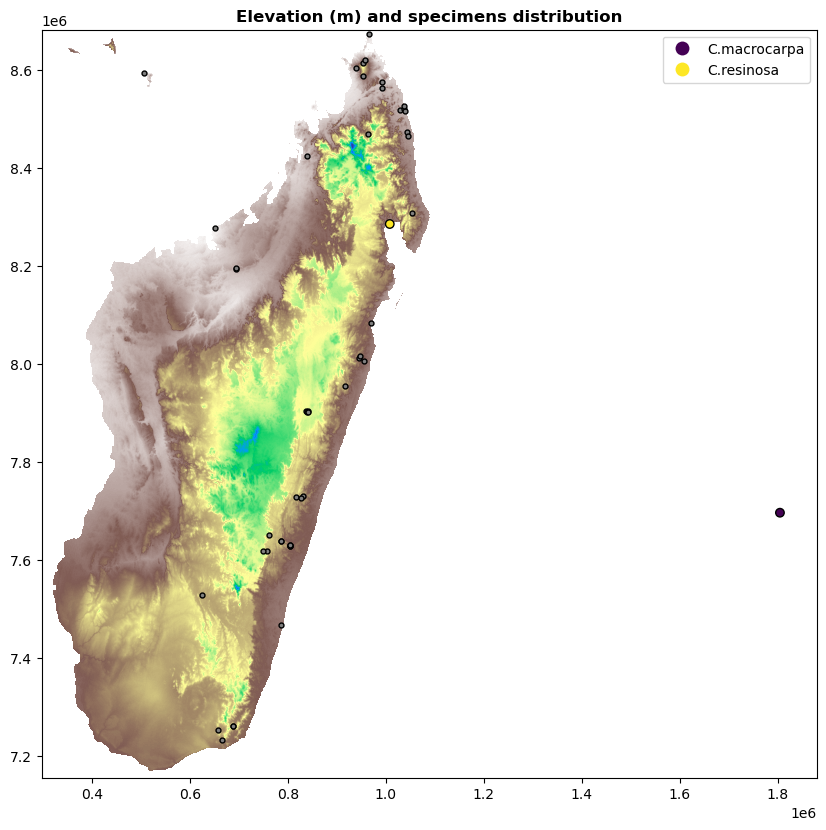

In [210]:
# Plotting with matplotlib.pyplot, rasterio.show and GeoPandas.plot modules
with rasterio.open(CLIMATE_DIR / MADACLIM_CURRENT_TIF) as raster_enviro:

    fig, ax = plt.subplots(figsize=(10, 10))
    ax = rasterio.plot.show(raster_enviro.read(1, masked=True), transform=raster_enviro.transform, cmap="terrain", ax=ax, title="Elevation (m) and specimens distribution + nodata specimens")
    # cbar = plt.colorbar(im)
    # cbar.ax.set_ylabel("bio1_Annual Mean Temperature")
    # plt.title("Bioclim1 and species distribution", weight="bold")
    # ax.set_aspect("equal")
    gdf_knowns.drop(mostly_nodata_specimens.index).plot(ax=ax, color="grey", markersize=50, marker=".", edgecolor="k")
    mostly_nodata_specimens.plot(column="Species", ax=ax, cmap="viridis", markersize=150, marker=".", legend=True, edgecolor="k")

Let's see if we can get back the C.resinosa to a very close but "On Island" position so we can get a similar value

In [261]:
# Copying 2 rows for tests
test_df = mostly_nodata_specimens.append(mostly_nodata_specimens.iloc[1, :])
test_df = test_df.append(test_df.iloc[1, :])
test_df

/tmp/ipykernel_129533/3040201295.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = mostly_nodata_specimens.append(mostly_nodata_specimens.iloc[1, :])
/tmp/ipykernel_129533/3040201295.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(test_df.iloc[1, :])


Species Species code Population code      GBS sequence  \
28  C.macrocarpa          MAC             MAC  C_macrocarpa-pet   
38    C.resinosa         RES1             A71     C_resinosa_A8   
38    C.resinosa         RES1             A71     C_resinosa_A8   
38    C.resinosa         RES1             A71     C_resinosa_A8   

   Botanical series Genome size (2C. pg) Latitude  Longitude  \
28              Mau                 1.17  -20.378    57.4300   
38     Multiflorae                  1.27   -15.45    49.7333   
38     Multiflorae                  1.27   -15.45    49.7333   
38     Multiflorae                  1.27   -15.45    49.7333   

                           geometry  \
28  POINT (1804918.843 7696851.850)   
38  POINT (1008284.884 8286298.730)   
38  POINT (1008284.884 8286298.730)   
38  POINT (1008284.884 8286298.730)   

                                        all_vals_clim  ...  \
28  [-32768, -32768, -32768, -32768, -32768, -3276...  ...   
38  [-32768, -32768, -32768, -32768, -32768, -3276...  ...   
38  [-32768, -32768, -32768, -32768, -32768, -3276...  ...   
38  [-32768, -32768, -32768, -32768, -32768, -3276...  ...   

   clim_layer70 : Number of dry months in the year  env_layer1 : Altitude (m)  \
28                                        -32768.0                   -32768.0   
38                                        -32768.0                   -32768.0   
38                                        -32768.0                   -32768.0   
38                                        -32768.0                   -32768.0   

    env_layer2 : Slope (in degree)  \
28                        -32768.0   
38                        -32768.0   
38                        -32768.0   
38                        -32768.0   

    env_layer3 : Aspect (clockwise from North, in degree)  \
28                                           -32768.0       
38                                           -32768.0       
38                                           -32768.0       
38                                           -32768.0       

    env_layer4 : Solar radiation (Wh.m-2.day-1)  \
28                                     -32768.0   
38                                     -32768.0   
38                                     -32768.0   
38                                     -32768.0   

    env_layer5 : Geology (Kew Botanical Garden, 1997)  \
28                                           -32768.0   
38                                           -32768.0   
38                                           -32768.0   
38                                           -32768.0   

    env_layer6 : Soil (Pelletier, 1981)  \
28                             -32768.0   
38                             -32768.0   
38                             -32768.0   
38                             -32768.0   

    env_layer7 : Vegetation (Kew Botanical Garden, 2007)  \
28                                           -32768.0      
38                                               25.0      
38                                               25.0      
38                                               25.0      

    env_layer8 : Watersheds (Pearson, 2009)  \
28                                 -32768.0   
38                                 -32768.0   
38                                 -32768.0   
38                                 -32768.0   

    env_layer9 : Percentage of forest cover for the year 2010 (%).  
28                                           -32768.0               
38                                           -32768.0               
38                                           -32768.0               
38                                           -32768.0               

[4 rows x 90 columns]

In [262]:
# Replacing names and values manually
test_df.iloc[2, 8] = Point(1008284.884, 8290298.730)
test_df.iloc[2, 0] = "TEST1"

test_df.iloc[3, 8] = Point(1008284.884, 8292298.730)
test_df.iloc[3, 0] = "TEST2"


In [371]:
# Plotting with matplotlib.pyplot, rasterio.show and GeoPandas.plot modules
with rasterio.open(CLIMATE_DIR / MADACLIM_CURRENT_TIF) as raster_enviro:

    fig, ax = plt.subplots(figsize=(15, 15))
    ax = rasterio.plot.show(raster_enviro.read(1, masked=True), transform=raster_enviro.transform, cmap="terrain", ax=ax, title="Elevation (m) and tests for C.resinosa")
    # cbar = plt.colorbar(im)
    # cbar.ax.set_ylabel("bio1_Annual Mean Temperature")
    # plt.title("Bioclim1 and species distribution", weight="bold")
    # ax.set_aspect("equal")
    gdf_knowns.drop(mostly_nodata_specimens.index).plot(ax=ax, color="grey", markersize=50, marker=".", edgecolor="k")
    test_df.plot(column="Species", ax=ax, cmap="viridis", markersize=150, marker="x", legend=True, edgecolor="k", alpha=0.5)

/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/geopandas/plotting.py:306: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  collection = ax.scatter(x, y, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)


Now we see that the Yellow X mark is now on the coast and still in the same elevation zone. We could alter that point and keep that value.

Let's test that range see where we have the closest to the original point:

POINT (1008284.884 8286298.730) -> Point(1008284.884, 8292298.730)

In [263]:
# To convert to initial GPS lon/lat format
print(
    f"""
    Initial latitude value to replace in known dataframe for specimen {mostly_nodata_specimens.loc[38, 'GBS sequence']} = 
    {gpd.GeoSeries(Point(1008284.884, 8292298.730), crs=raster_clim.crs).to_crs(4326).y[0]}
    """
)


    Initial latitude value to replace in known dataframe for specimen C_resinosa_A8 = 
    -15.395940696691255
    


In [339]:
optimize_df = mostly_nodata_specimens.drop([28]).iloc[:, :9]

In [340]:
optimize_df

Species Species code Population code   GBS sequence Botanical series  \
38  C.resinosa         RES1             A71  C_resinosa_A8     Multiflorae    

   Genome size (2C. pg) Latitude  Longitude                         geometry  
38                 1.27   -15.45    49.7333  POINT (1008284.884 8286298.730)

In [342]:
# Create testing df to sample rasters
test_range_y = np.linspace(8286298.730, 8292298.730, 20)
for i in range (10):
    optimize_df = optimize_df.append(optimize_df.iloc[0, :])
    optimize_df.iloc[i, 8] = Point(1008284.884, test_range_y[i])



/tmp/ipykernel_129533/1807688018.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  optimize_df = optimize_df.append(optimize_df.iloc[0, :])
/tmp/ipykernel_129533/1807688018.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  optimize_df = optimize_df.append(optimize_df.iloc[0, :])
/tmp/ipykernel_129533/1807688018.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  optimize_df = optimize_df.append(optimize_df.iloc[0, :])
/tmp/ipykernel_129533/1807688018.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  optimize_df = optimize_df.append(optimize_df.iloc[0, :])
/tmp/ipykernel_129533/1807688018.py:4: FutureWarning: The frame.append metho

In [343]:
optimize_df = optimize_df.reset_index().drop(columns="index")
optimize_df

Species Species code Population code   GBS sequence Botanical series  \
0   C.resinosa         RES1             A71  C_resinosa_A8     Multiflorae    
1   C.resinosa         RES1             A71  C_resinosa_A8     Multiflorae    
2   C.resinosa         RES1             A71  C_resinosa_A8     Multiflorae    
3   C.resinosa         RES1             A71  C_resinosa_A8     Multiflorae    
4   C.resinosa         RES1             A71  C_resinosa_A8     Multiflorae    
5   C.resinosa         RES1             A71  C_resinosa_A8     Multiflorae    
6   C.resinosa         RES1             A71  C_resinosa_A8     Multiflorae    
7   C.resinosa         RES1             A71  C_resinosa_A8     Multiflorae    
8   C.resinosa         RES1             A71  C_resinosa_A8     Multiflorae    
9   C.resinosa         RES1             A71  C_resinosa_A8     Multiflorae    
10  C.resinosa         RES1             A71  C_resinosa_A8     Multiflorae    

   Genome size (2C. pg) Latitude  Longitude                         geometry  
0                  1.27   -15.45    49.7333  POINT (1008284.884 8286298.730)  
1                  1.27   -15.45    49.7333  POINT (1008284.884 8286614.519)  
2                  1.27   -15.45    49.7333  POINT (1008284.884 8286930.309)  
3                  1.27   -15.45    49.7333  POINT (1008284.884 8287246.098)  
4                  1.27   -15.45    49.7333  POINT (1008284.884 8287561.888)  
5                  1.27   -15.45    49.7333  POINT (1008284.884 8287877.677)  
6                  1.27   -15.45    49.7333  POINT (1008284.884 8288193.467)  
7                  1.27   -15.45    49.7333  POINT (1008284.884 8288509.256)  
8                  1.27   -15.45    49.7333  POINT (1008284.884 8288825.046)  
9                  1.27   -15.45    49.7333  POINT (1008284.884 8289140.835)  
10                 1.27   -15.45    49.7333  POINT (1008284.884 8286298.730)

In [344]:
# Checking if we can sample from both raster_clim and raster_env with those new coords for that specimen
sample_test = sample_from_raster(optimize_df, "geometry", MADACLIM_CURRENT_TIF, ENVIRO_TIF, mada_layers)


Num specimens extracted from madaclim_current.tif : 11
Num specimens extracted from madaclim_enviro.tif : 11

Number of specimens containing 'nodata' values when extracting from madaclim_current.tif = 4
List of specimen index with at least 1 no data point : [0, 1, 2, 10]

Number of specimens containing 'nodata' values when extracting from madaclim_enviro.tif = 7
List of specimen index with at least 1 no data point : [0, 1, 2, 3, 4, 5, 10]



In [345]:
# Features with number of datapoints with nodata
nodata_features = (sample_test[0][features] == nodata_val).sum()

In [346]:
for i in range(max(nodata_features) + 1):
    if nodata_features[(nodata_features == i)].sum() > 0:
        print(f"Number of datapoints = {nodata_val} present  in = {i} feature(s)")
        print(nodata_features[(nodata_features == i)].sum())

Number of datapoints = -32768.0 present  in = 4 feature(s)
308
Number of datapoints = -32768.0 present  in = 7 feature(s)
7


In [350]:
sample_test[0]

Species Species code Population code   GBS sequence Botanical series  \
0   C.resinosa         RES1             A71  C_resinosa_A8     Multiflorae    
1   C.resinosa         RES1             A71  C_resinosa_A8     Multiflorae    
2   C.resinosa         RES1             A71  C_resinosa_A8     Multiflorae    
3   C.resinosa         RES1             A71  C_resinosa_A8     Multiflorae    
4   C.resinosa         RES1             A71  C_resinosa_A8     Multiflorae    
5   C.resinosa         RES1             A71  C_resinosa_A8     Multiflorae    
6   C.resinosa         RES1             A71  C_resinosa_A8     Multiflorae    
7   C.resinosa         RES1             A71  C_resinosa_A8     Multiflorae    
8   C.resinosa         RES1             A71  C_resinosa_A8     Multiflorae    
9   C.resinosa         RES1             A71  C_resinosa_A8     Multiflorae    
10  C.resinosa         RES1             A71  C_resinosa_A8     Multiflorae    

   Genome size (2C. pg) Latitude  Longitude                         geometry  \
0                  1.27   -15.45    49.7333  POINT (1008284.884 8286298.730)   
1                  1.27   -15.45    49.7333  POINT (1008284.884 8286614.519)   
2                  1.27   -15.45    49.7333  POINT (1008284.884 8286930.309)   
3                  1.27   -15.45    49.7333  POINT (1008284.884 8287246.098)   
4                  1.27   -15.45    49.7333  POINT (1008284.884 8287561.888)   
5                  1.27   -15.45    49.7333  POINT (1008284.884 8287877.677)   
6                  1.27   -15.45    49.7333  POINT (1008284.884 8288193.467)   
7                  1.27   -15.45    49.7333  POINT (1008284.884 8288509.256)   
8                  1.27   -15.45    49.7333  POINT (1008284.884 8288825.046)   
9                  1.27   -15.45    49.7333  POINT (1008284.884 8289140.835)   
10                 1.27   -15.45    49.7333  POINT (1008284.884 8286298.730)   

                                        all_vals_clim  ...  \
0   [-32768, -32768, -32768, -32768, -32768, -3276...  ...   
1   [-32768, -32768, -32768, -32768, -32768, -3276...  ...   
2   [-32768, -32768, -32768, -32768, -32768, -3276...  ...   
3   [188, 223, 219, 210, 193, 178, 178, 177, 178, ...  ...   
4   [188, 223, 219, 210, 193, 178, 178, 177, 178, ...  ...   
5   [188, 223, 219, 210, 193, 178, 178, 177, 178, ...  ...   
6   [188, 223, 219, 210, 193, 178, 178, 177, 178, ...  ...   
7   [188, 223, 219, 210, 193, 178, 178, 177, 178, ...  ...   
8   [188, 223, 219, 210, 193, 178, 178, 177, 178, ...  ...   
9   [188, 223, 219, 210, 193, 178, 178, 176, 178, ...  ...   
10  [-32768, -32768, -32768, -32768, -32768, -3276...  ...   

   clim_layer70 : Number of dry months in the year  env_layer1 : Altitude (m)  \
0                                         -32768.0                   -32768.0   
1                                         -32768.0                   -32768.0   
2                                         -32768.0                   -32768.0   
3                                              1.0                        6.0   
4                                              1.0                        6.0   
5                                              1.0                        6.0   
6                                              1.0                       12.0   
7                                              1.0                       12.0   
8                                              1.0                       12.0   
9                                              1.0                       11.0   
10                                        -32768.0                   -32768.0   

    env_layer2 : Slope (in degree)  \
0                         -32768.0   
1                         -32768.0   
2                         -32768.0   
3                              1.0   
4                              1.0   
5                              1.0   
6                              1.0   
7                              1.0   
8                              1.0   

In [349]:
# To filter tests with ALL values present
sample_test[0][(sample_test[0][features] != nodata_val).all(axis=1)]

Species Species code Population code   GBS sequence Botanical series  \
6  C.resinosa         RES1             A71  C_resinosa_A8     Multiflorae    
7  C.resinosa         RES1             A71  C_resinosa_A8     Multiflorae    
8  C.resinosa         RES1             A71  C_resinosa_A8     Multiflorae    
9  C.resinosa         RES1             A71  C_resinosa_A8     Multiflorae    

  Genome size (2C. pg) Latitude  Longitude                         geometry  \
6                 1.27   -15.45    49.7333  POINT (1008284.884 8288193.467)   
7                 1.27   -15.45    49.7333  POINT (1008284.884 8288509.256)   
8                 1.27   -15.45    49.7333  POINT (1008284.884 8288825.046)   
9                 1.27   -15.45    49.7333  POINT (1008284.884 8289140.835)   

                                       all_vals_clim  ...  \
6  [188, 223, 219, 210, 193, 178, 178, 177, 178, ...  ...   
7  [188, 223, 219, 210, 193, 178, 178, 177, 178, ...  ...   
8  [188, 223, 219, 210, 193, 178, 178, 177, 178, ...  ...   
9  [188, 223, 219, 210, 193, 178, 178, 176, 178, ...  ...   

  clim_layer70 : Number of dry months in the year  env_layer1 : Altitude (m)  \
6                                             1.0                       12.0   
7                                             1.0                       12.0   
8                                             1.0                       12.0   
9                                             1.0                       11.0   

   env_layer2 : Slope (in degree)  \
6                             1.0   
7                             1.0   
8                             1.0   
9                             1.0   

   env_layer3 : Aspect (clockwise from North, in degree)  \
6                                              193.0       
7                                              193.0       
8                                              193.0       
9                                               64.0       

   env_layer4 : Solar radiation (Wh.m-2.day-1)  \
6                                       7744.0   
7                                       7744.0   
8                                       7744.0   
9                                       7786.0   

   env_layer5 : Geology (Kew Botanical Garden, 1997)  \
6                                                1.0   
7                                                1.0   
8                                                1.0   
9                                                1.0   

   env_layer6 : Soil (Pelletier, 1981)  \
6                                 21.0   
7                                 21.0   
8                                 21.0   
9                                 21.0   

   env_layer7 : Vegetation (Kew Botanical Garden, 2007)  \
6                                                4.0      
7                                                4.0      
8                                                4.0      
9                                               16.0      

   env_layer8 : Watersheds (Pearson, 2009)  \
6                                      2.0   
7                                      2.0   
8                                      2.0   
9                                      2.0   

   env_layer9 : Percentage of forest cover for the year 2010 (%).  
6                                               10.0               
7                                               10.0               
8                                               10.0               
9                                                0.0               

[4 rows x 90 columns]

In [399]:
c_resinosa_resample_index = 6

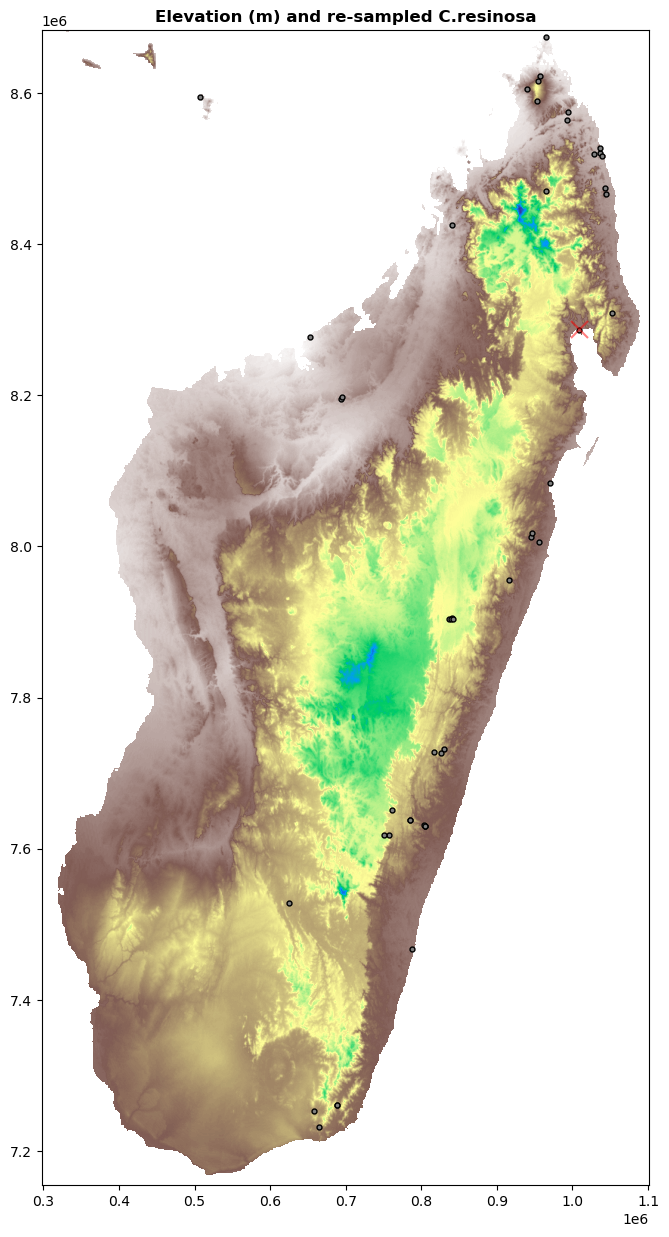

In [370]:
# Plotting with matplotlib.pyplot, rasterio.show and GeoPandas.plot modules
with rasterio.open(CLIMATE_DIR / MADACLIM_CURRENT_TIF) as raster_enviro:

    fig, ax = plt.subplots(figsize=(15, 15))
    ax = rasterio.plot.show(raster_enviro.read(1, masked=True), transform=raster_enviro.transform, cmap="terrain", ax=ax, title="Elevation (m) and re-sampled C.resinosa")
    # cbar = plt.colorbar(im)
    # cbar.ax.set_ylabel("bio1_Annual Mean Temperature")
    # plt.title("Bioclim1 and species distribution", weight="bold")
    # ax.set_aspect("equal")
    gdf_knowns.drop(mostly_nodata_specimens.index[0]).plot(ax=ax, color="grey", markersize=50, marker=".", edgecolor="k")
    sample_test[0].iloc[c_resinosa_resample_index:c_resinosa_resample_index+1, :].plot(ax=ax, color="red", markersize=150, marker="x", legend=True, alpha=0.5)

In [398]:
c_resinosa_ori_index = gdf_knowns[gdf_knowns["GBS sequence"] == "C_resinosa_A8"].index[0]
c_resinosa_ori_index

38

In [402]:
c_resinosa_toreplace = sample_test[0].iloc[c_resinosa_resample_index:c_resinosa_resample_index + 1, :]
c_resinosa_toreplace = c_resinosa_toreplace.rename(index={6: mostly_nodata_specimens[mostly_nodata_specimens["Species"] == "C.resinosa"].index[0]})
c_resinosa_toreplace

Species Species code Population code   GBS sequence Botanical series  \
38  C.resinosa         RES1             A71  C_resinosa_A8     Multiflorae    

   Genome size (2C. pg) Latitude  Longitude                         geometry  \
38                 1.27   -15.45    49.7333  POINT (1008284.884 8288193.467)   

                                        all_vals_clim  ...  \
38  [188, 223, 219, 210, 193, 178, 178, 177, 178, ...  ...   

   clim_layer70 : Number of dry months in the year  env_layer1 : Altitude (m)  \
38                                             1.0                       12.0   

    env_layer2 : Slope (in degree)  \
38                             1.0   

    env_layer3 : Aspect (clockwise from North, in degree)  \
38                                              193.0       

    env_layer4 : Solar radiation (Wh.m-2.day-1)  \
38                                       7744.0   

    env_layer5 : Geology (Kew Botanical Garden, 1997)  \
38                                                1.0   

    env_layer6 : Soil (Pelletier, 1981)  \
38                                 21.0   

    env_layer7 : Vegetation (Kew Botanical Garden, 2007)  \
38                                                4.0      

    env_layer8 : Watersheds (Pearson, 2009)  \
38                                      2.0   

    env_layer9 : Percentage of forest cover for the year 2010 (%).  
38                                               10.0               

[1 rows x 90 columns]

In [405]:
# Replacing on original df with same index
gdf_knowns = gdf_knowns[gdf_knowns["GBS sequence"] != "C_resinosa_A8"].append(c_resinosa_toreplace).sort_index()

/tmp/ipykernel_129533/4092422516.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf_knowns = gdf_knowns[gdf_knowns["GBS sequence"] != "C_resinosa_A8"].append(c_resinosa_toreplace).sort_index()
/home/local/USHERBROOKE/lals2906/anaconda3/envs/aphylo_cm/lib/python3.11/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / UTM zone 38S (the single non-null crs provided).
  warnings.warn(


In [406]:
gdf_knowns

Species Species code Population code  \
0          C.abbayesii          ABA            A601   
1     C.ambodirianenis          AMB            A572   
2        C.ambongensis        AMBON           BR071   
3       C.ankaranensis         ANK1            A525   
4       C.ankaranensis         ANK2            A808   
5         C.arenesiana          ARE            A403   
6         C.augagneuri         AUGA            A966   
7         C.bertrandii         BERT              A5   
8      C.betamponensis          BET            A573   
9          C.bissetiae         BISS           BR031   
10         C.boinensis         BOIN           BR051   
11        C.boiviniana          BOI            A980   
12          C.bonnieri          BON            A535   
13            C.costei          COS            A956   
14         C.coursiana          COU            A570   
15        C.daphnoides          DAP            A317   
16     C.dolichophylla          DOL            A206   
17          C.dubardii          DUB            A969   
18  C.farafanganensis           FAR            A208   
19            C.heimii          HEI            A516   
20          C.homollei          HOM            A945   
21       C.humblotiana         HUMB            A230   
22          C.jumellei          JUM            A974   
23    C.kianjavatensis         KIA2            A602   
24    C.kianjavatensis         KIA1            A213   
25        C.lancifolia          LAN            A320   
26            C.leroyi         AND1            A227   
27            C.leroyi          LER            A315   
28        C.macrocarpa          MAC             MAC   
29      C.mangoroensis         MAN1            A401   
30      C.mangoroensis         MAN2            A402   
31           C.milotti         MIL1            A721   
32           C.milotti         MIL2            A222   
33         C.mogenetti          MOG            A975   
34      C.montis-sacri          MON            A321   
35          C.perrieri         PER1             A12   
36       C.pervilleana         PERV            A957   
37     C.ratsimamangae          RAT            A528   
38          C.resinosa         RES1             A71   
39         C.richardii          RIC            A575   
40     C.sahafaryensis         SAHA            A978   
41         C.sakarahae          SAK            A304   
42         C.tetragona          TET            A252   
43        C.tsirananae          TSI            A515   
44     C.vatovavyensis          VAT            A830   
45          C.vianneyi         VIA1             A20   
46          C.vianneyi         VIA2            A946   
47      C.vohemarensis         VOHE            A977   
48  C_andrambovatensis         AND2            A310   

                          GBS sequence Botanical series Genome size (2C. pg)  \
0                     C_abbayesii_A601         Millotii                 1.25   
1               C_ambodirianensis_A572         Millotii                 1.27   
2                        C_ambongensis       Baracoffea                 1.16   
3                  C_ankaranensis_A525     Multiflorae                  1.17   
4                                  NaN     Multiflorae                  1.17   
5                    C_arenesiana_A403     Multiflorae                  1.11   
6                    C_augagneuri_A966   Subterminales                  1.18   
7                      C_bertrandii_A5     Multiflorae                  1.22   
8                                  NaN     Multiflorae                  1.26   
9                          C_bissetiae       Baracoffea                 1.19   
10                         C_boinensis       Baracoffea                 1.15   
11                   C_boiviniana_A980   Subterminales                  1.00   
12                     C_bonnieri_A535   Subterminales                  1.06   
13                       C_costei_A956     Multiflorae                  1.16   
14                                 NaN     Multiflorae          

#### Removing C.macrocarpa

In [ ]:
#TODO

### Missing data imputation based on KNN and Multivarite imputation

In [408]:
#TODO

Convert Genome size and coords to float

In [ ]:
# Convert Genome size and Latitude to floats
# gdf_["Genome size (2C. pg)"] = gdf_gbs["Genome size (2C. pg)"].astype(float)
# gdf_gbs["Latitude"] = gdf_gbs["Latitude"].astype(float)

**DATA TRANSFORMATION INFORMATION:**

[Madaclim methods for climate db](https://madaclim.cirad.fr/methods-climate/)

## Climate data exploration

### Distributions per layer set

**Layers description reminder**

- layers1_12 ---> Monthly minimum temperature (C x 10)
- l13_24 ---> Monthly maximum temperature (C x 10)
- l25_36 ---> Monthly total precipitation (mm.month-1)
- l37_55 ---> bioclim
- l56_67 ---> Monthly potential evapotranspiration (mm.month-1)
- l68 ---> Annual potential evapotranspiration (mm)
- l69 ---> Annual climatic water deficit (mm)
- l70 ---> Number of dry months in the year

In [ ]:
# Hardcoded
mada_layers_list = [d for d in mada_layers.items()]
layers1_12 = mada_layers_list[0:12]
layers13_24 = mada_layers_list[12:24]
layers25_36 = mada_layers_list[24:36]
layers37_55 = mada_layers_list[36:55]
layers56_67 = mada_layers_list[55:67]
layer68 = [mada_layers_list[67]]
layer69 = [mada_layers_list[68]]
layer70 = [mada_layers_list[69]]


In [ ]:
# Same format as df
def get_layers(layers : dict, start : int, end=None):
    if end is None:
        end = start
    if start <1 :
        raise ValueError("Non-zero indexing for layers")
    elif end > len(layers):
        raise ValueError("Select a maximum that is within the range of layers")
    elif start > end:
        raise ValueError("Start layer must come before end layer")
    else :         
        selected_layers = []
        for i, (k, v) in enumerate(layers.items(), start=1):
            if i >= start and i <= end:
                selected_layers.append(f"{k} : {v}")
        return selected_layers

In [ ]:
# Example for layers 68 to 70
print(get_layers(mada_layers, 68, 70))
print(f"\nThere are {len(mada_layers)} layers")

['layer68 : Annual potential evapotranspiration (mm)', 'layer69 : Annual climatic water deficit (mm)', 'layer70 : Number of dry months in the year']

There are 70 layers


In [ ]:
# Specimens + positions cols
gdf_gbs.columns.to_list()[0:4]

['Genome size (2C. pg)', 'Longitude', 'Latitude', 'geometry']

In [ ]:
# Subset df for layers 1 to 12
monthly_min = gdf_gbs.columns.to_list()[: l1_index] + get_layers(mada_layers, 1, 12)

gdf_gbs[monthly_min].head()

Genome size (2C. pg)  Longitude   Latitude  \
Species code                                               
ABA                           1.25  46.862400 -24.754100   
AMB                           1.27  48.943300 -18.452200   
AMBON                         1.16  46.419806 -15.574583   
ANK1                          1.17  49.543300 -12.949100   
ARE                           1.11  48.200000 -18.933300   

                                    geometry  \
Species code                                   
ABA           POINT (688328.240 7260998.023)   
AMB           POINT (916635.952 7955240.629)   
AMBON         POINT (652237.905 8277614.406)   
ANK1          POINT (993250.150 8564104.062)   
ARE           POINT (837072.915 7903496.321)   

                                                     all_layers  \
Species code                                                      
ABA           [155, 195, 188, 171, 136, 122, 120, 124, 138, ...   
AMB           [157, 203, 199, 185, 164, 149, 142, 139, 144, ...   
AMBON         [222, 236, 238, 235, 217, 199, 191, 193, 205, ...   
ANK1          [206, 228, 227, 224, 211, 192, 186, 188, 194, ...   
ARE           [130, 176, 166, 153, 126, 107, 109, 107, 114, ...   

              layer1 : Monthly minimum temperature (C x 10)_January  \
Species code                                                          
ABA                                                       155.0       
AMB                                                       157.0       
AMBON                                                     222.0       
ANK1                                                      206.0       
ARE                                                       130.0       

              layer2 : Monthly minimum temperature (C x 10)_February  \
Species code                                                           
ABA                                                       195.0        
AMB                                                       203.0        
AMBON                                                     236.0        
ANK1                                                      228.0        
ARE                                                       176.0        

              layer3 : Monthly minimum temperature (C x 10)_March  \
Species code                                                        
ABA                                                       188.0     
AMB                                                       199.0     
AMBON                                                     238.0     
ANK1                                                      227.0     
ARE                                                       166.0     

              layer4 : Monthly minimum temperature (C x 10)_April  \
Species code                                                        
ABA                                                       171.0     
AMB                                                       185.0     
AMBON                                                     235.0     
ANK1                                                      224.0     
ARE                                                       153.0     

              layer5 : Monthly minimum temperature (C x 10)_May  \
Species code                                                      
ABA                                                       136.0   
AMB                                                       164.0   
AMBON                                                     217.0   
ANK1                                                      211.0   
ARE                                                       126.0   

              layer6 : Monthly minimum temperature (C x 10)_June  \
Species code                                                       
ABA                                                       122.0    
AMB                                                       149.0    
AMBON                                                     199.0    
ANK1 

In [ ]:
gdf_gbs.iloc[:,l1_index:].columns.to_list()

['layer1 : Monthly minimum temperature (C x 10)_January',
 'layer2 : Monthly minimum temperature (C x 10)_February',
 'layer3 : Monthly minimum temperature (C x 10)_March',
 'layer4 : Monthly minimum temperature (C x 10)_April',
 'layer5 : Monthly minimum temperature (C x 10)_May',
 'layer6 : Monthly minimum temperature (C x 10)_June',
 'layer7 : Monthly minimum temperature (C x 10)_July',
 'layer8 : Monthly minimum temperature (C x 10)_August',
 'layer9 : Monthly minimum temperature (C x 10)_September',
 'layer10 : Monthly minimum temperature (C x 10)_October',
 'layer11 : Monthly minimum temperature (C x 10)_November',
 'layer12 : Monthly minimum temperature (C x 10)_December',
 'layer13 : Monthly maximum temperature (C x 10)_January',
 'layer14 : Monthly maximum temperature (C x 10)_February',
 'layer15 : Monthly maximum temperature (C x 10)_March',
 'layer16 : Monthly maximum temperature (C x 10)_April',
 'layer17 : Monthly maximum temperature (C x 10)_May',
 'layer18 : Monthly max

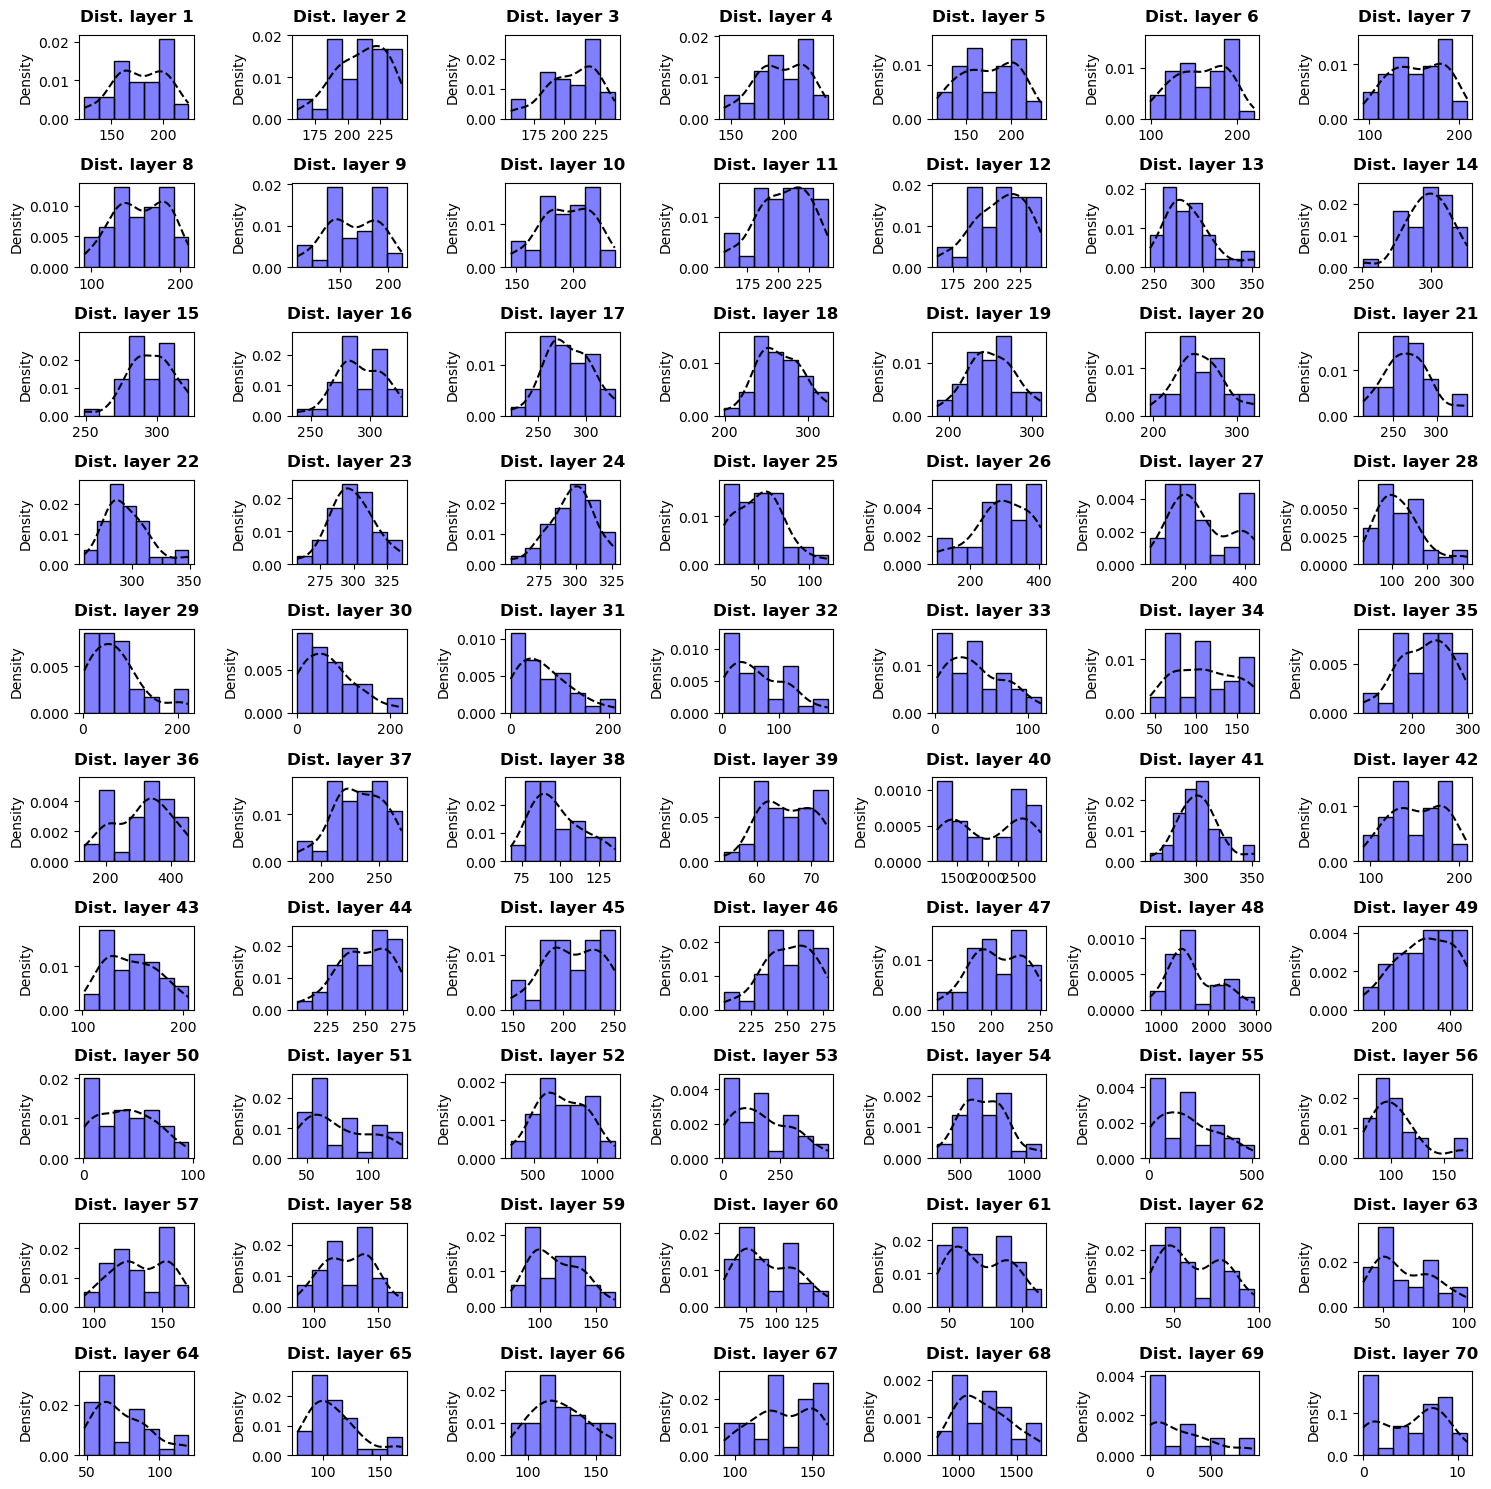

In [ ]:
def madaclim_specimens_hists(gdf):
    fig, axes = plt.subplots(10, 7, figsize=(15,15))
    axes = axes.ravel()
    layers = gdf.iloc[:,l1_index:].columns.to_list()
    for i, layer in enumerate(layers):
        sns.histplot(
            data=gdf,
            x=layer,
            color="blue",
            ax=axes[i],
            kde=True, stat="density",
            line_kws={"linestyle" : "--"}
        )
        axes[i].set_xlabel("")
        axes[i].lines[0].set_color("black")
        axes[i].set_title(f"Dist. layer {i+1}", pad=10, weight="bold")
    fig.tight_layout()

madaclim_specimens_hists(gdf_gbs)

In [ ]:
def check_normality(gdf):
    layers = gdf.iloc[:,l1_index:].columns.to_list()
    for i, layer in enumerate(layers):
        norm = shapiro(gdf[layer])
        if norm.pvalue < 0.05:
            print(f"layer {i+1} is not normally distributed since pval={norm.pvalue} < 0.05")
        # else:
        #     print(f"{layer} follows a normal distribution (null hypothesis)")
check_normality(gdf_gbs)

layer 13 is not normally distributed since pval=0.01563286781311035 < 0.05
layer 22 is not normally distributed since pval=0.026344725862145424 < 0.05
layer 27 is not normally distributed since pval=0.006803478114306927 < 0.05
layer 28 is not normally distributed since pval=0.011577649042010307 < 0.05
layer 29 is not normally distributed since pval=0.003331586252897978 < 0.05
layer 30 is not normally distributed since pval=0.018307127058506012 < 0.05
layer 31 is not normally distributed since pval=0.028063109144568443 < 0.05
layer 32 is not normally distributed since pval=0.016017835587263107 < 0.05
layer 33 is not normally distributed since pval=0.018792366608977318 < 0.05
layer 34 is not normally distributed since pval=0.04594413936138153 < 0.05
layer 40 is not normally distributed since pval=0.0002975565439555794 < 0.05
layer 48 is not normally distributed since pval=0.007411393336951733 < 0.05
layer 51 is not normally distributed since pval=0.005776598118245602 < 0.05
layer 53 is n

In [ ]:
fig, ax = plt.subplots()
sns.histplot(data=gdf_gbs,x="Genome size (2C. pg)",color="orange",ax=ax,kde=True, stat="density",line_kws={"linestyle" : "--"})
ax.set_xlabel("")
ax.lines[0].set_color("black")
ax.set_title(f"Genome size distribution", pad=10, weight="bold")

Text(0.5, 1.0, 'Genome size distribution')

In [ ]:
norm_gs = shapiro(gdf_gbs["Genome size (2C. pg)"])
if norm_gs.pvalue > 0.05:
    print(f"Genome size distribution is normally distributed (pval = {norm_gs.pvalue:.4f})")

Genome size distribution is normally distributed (pval = 0.8546)


**Correlation to GPS position**

In [ ]:
def correlation_to_gps(gdf, features):
    pass

In [ ]:
# numpy solution to calculate correlation coefficient between 2d (lon/lat) and 1d (clim feature) arrays
print(np.corrcoef(gdf_gbs["Longitude"].values ,gdf_gbs[["Longitude", "Latitude"]].values.T)[0][2])

# Or directly with pandas .corr() method
print(gdf_gbs.corr()["Longitude"]["Latitude"])

0.5957018767885885
0.5957018767885888


/tmp/ipykernel_78223/4008967849.py:5: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(gdf_gbs.corr()["Longitude"]["Latitude"])


In [ ]:
# Correlation with Latitude
gdf_gbs.corr()[abs(gdf_gbs.corr()["Latitude"])>0.5]["Latitude"]

/tmp/ipykernel_78223/1189864861.py:2: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  gdf_gbs.corr()[abs(gdf_gbs.corr()["Latitude"])>0.5]["Latitude"]


Genome size (2C. pg)                                                    -0.553080
Longitude                                                                0.595702
Latitude                                                                 1.000000
layer1 : Monthly minimum temperature (C x 10)_January                    0.589604
layer3 : Monthly minimum temperature (C x 10)_March                      0.504263
layer4 : Monthly minimum temperature (C x 10)_April                      0.658330
layer5 : Monthly minimum temperature (C x 10)_May                        0.769960
layer6 : Monthly minimum temperature (C x 10)_June                       0.758555
layer7 : Monthly minimum temperature (C x 10)_July                       0.760966
layer8 : Monthly minimum temperature (C x 10)_August                     0.745333
layer9 : Monthly minimum temperature (C x 10)_September                  0.671613
layer10 : Monthly minimum temperature (C x 10)_October                   0.540008
layer18 : Monthl

In [ ]:
# Correlation with Longitude
gdf_gbs.corr()[abs(gdf_gbs.corr()["Longitude"])>0.5]["Longitude"]

/tmp/ipykernel_78223/4079369275.py:2: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  gdf_gbs.corr()[abs(gdf_gbs.corr()["Longitude"])>0.5]["Longitude"]


Longitude                                                 1.000000
Latitude                                                  0.595702
layer38 : bio2_Mean Diurnal Range(Mean(period max-min)   -0.538404
layer43 : bio7_Temperature Annual Range (5-6)            -0.613925
Name: Longitude, dtype: float64

We could use the most correlated features to impute missing Lat/Long : 
- **Lat** -> layer40 : bio4_Temperature Seasonality (C of V) with r2 = -0.9
- **Lon** -> layer43 : bio7_Temperature Annual Range (5-6) with r2 = -0.613925

In [ ]:
# Correlation with genome size
gdf_gbs.corr()[abs(gdf_gbs.corr()["Genome size (2C. pg)"])>0.5]["Genome size (2C. pg)"]

/tmp/ipykernel_78223/2233172131.py:2: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  gdf_gbs.corr()[abs(gdf_gbs.corr()["Genome size (2C. pg)"])>0.5]["Genome size (2C. pg)"]


Genome size (2C. pg)                               1.00000
Latitude                                          -0.55308
layer40 : bio4_Temperature Seasonality (C of V)    0.53222
Name: Genome size (2C. pg), dtype: float64

Text(0.5, 0.98, 'Correlation map for all 70 madaclim layers')

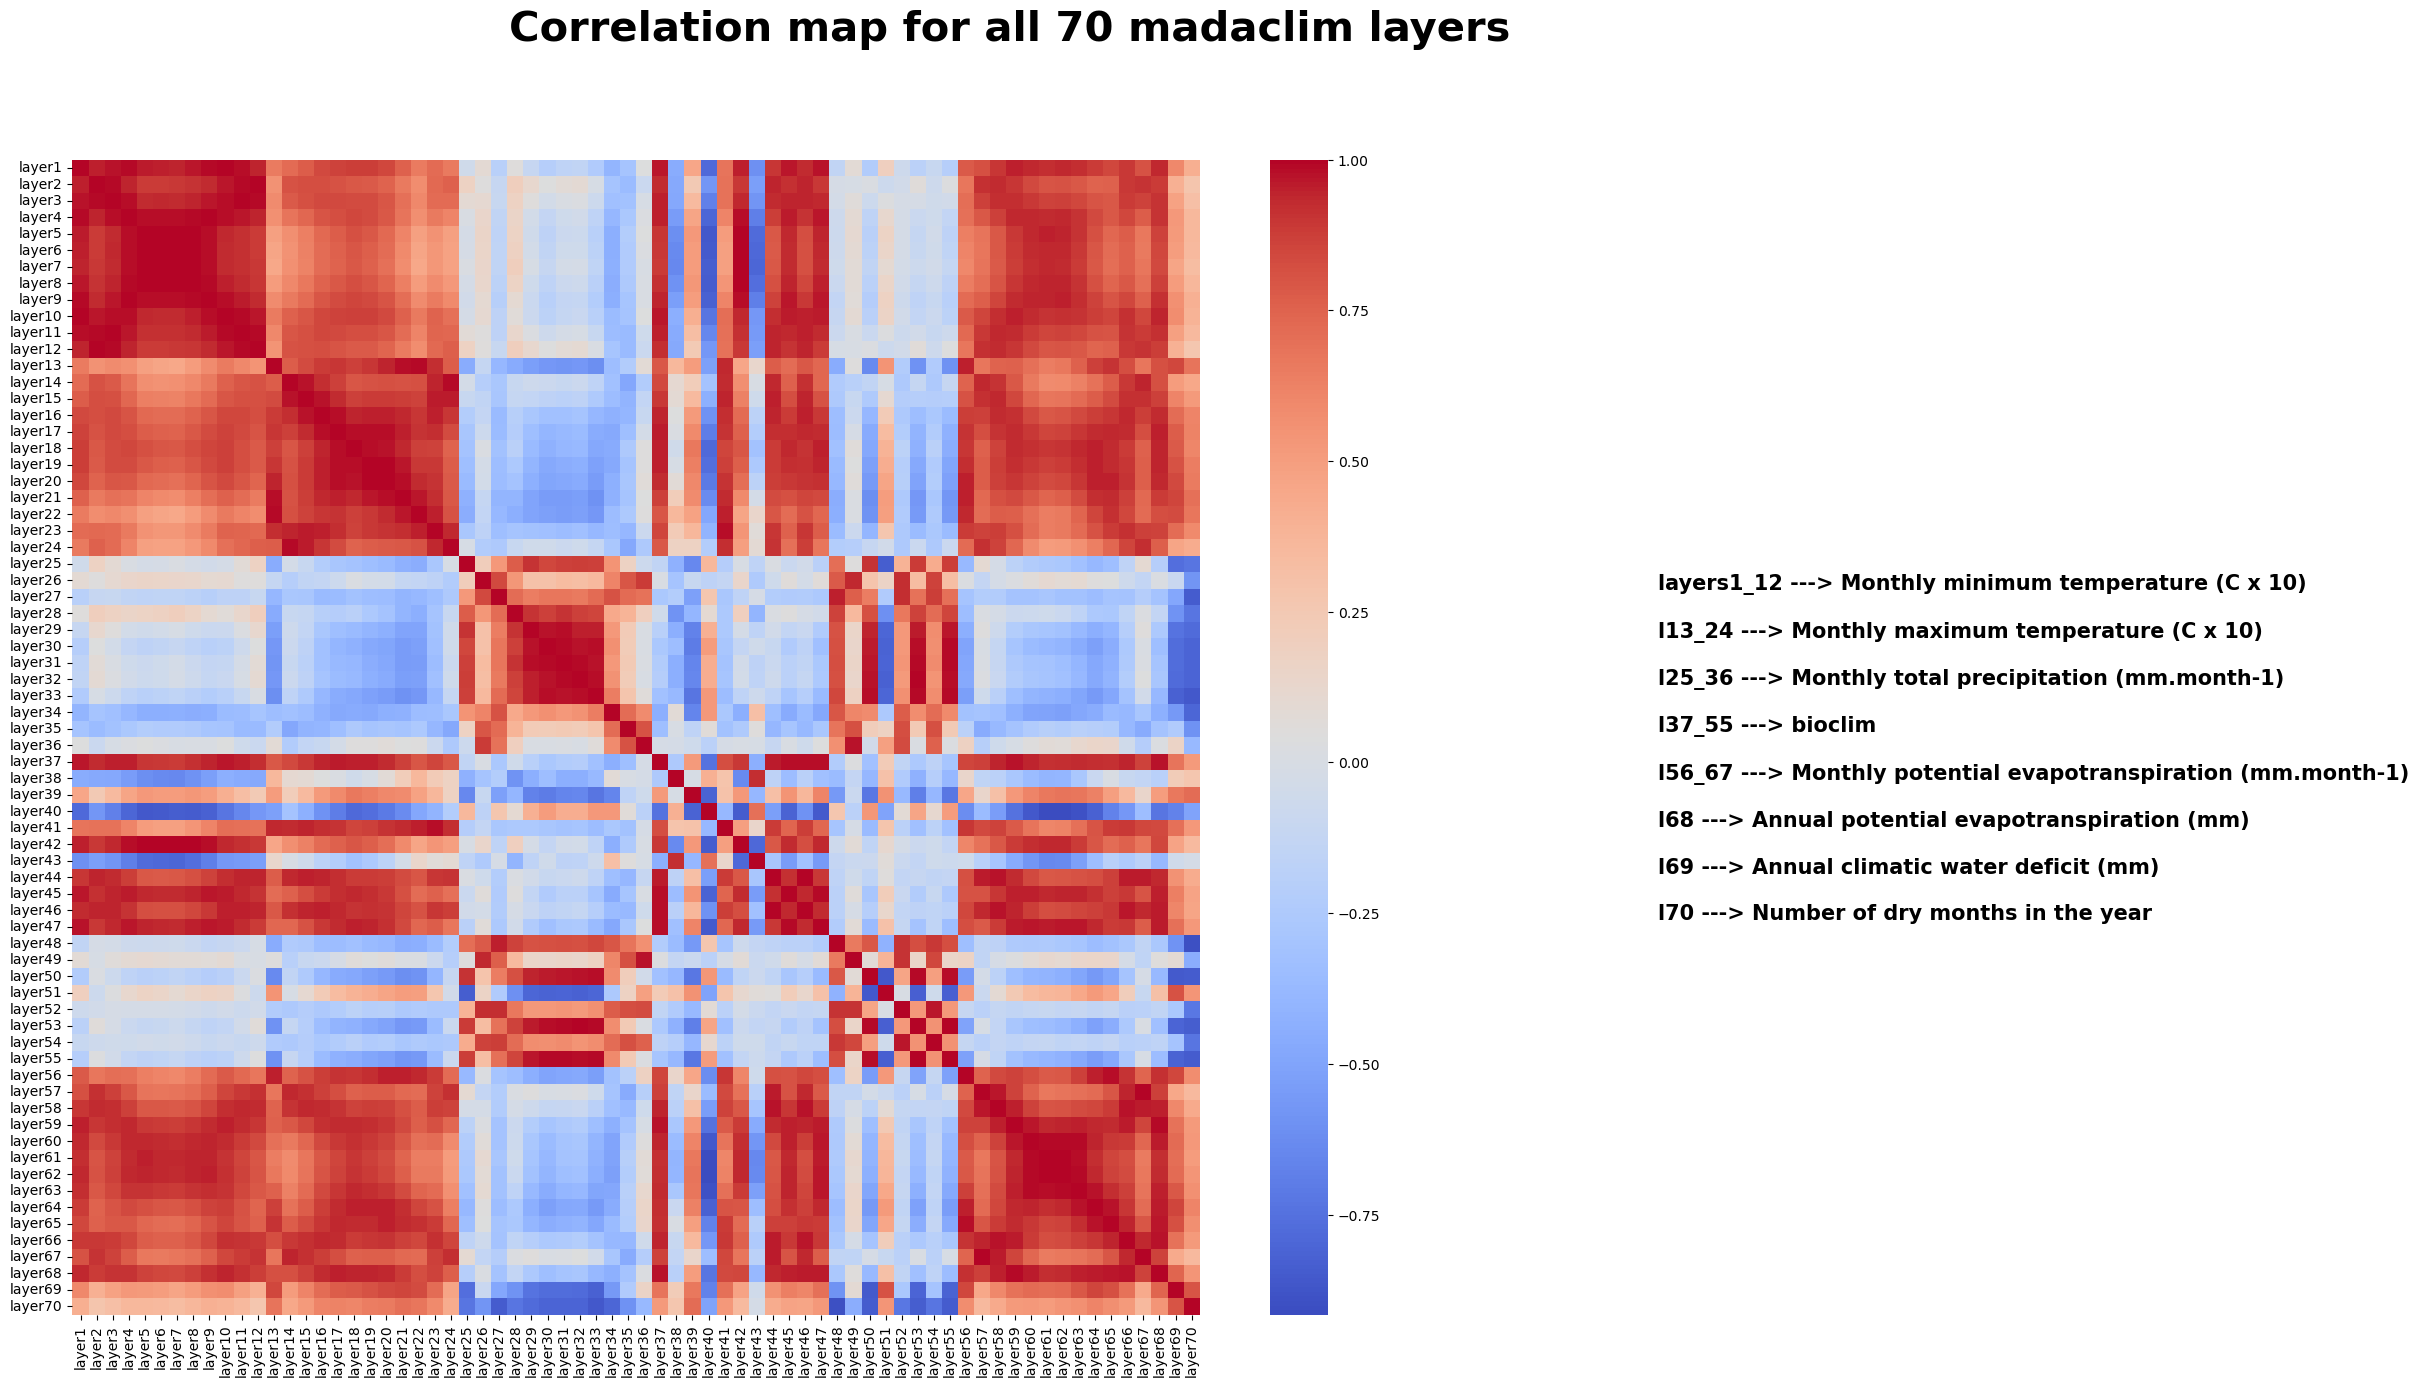

In [ ]:
# All pairs
layers_def = """

layers1_12 ---> Monthly minimum temperature (C x 10)

l13_24 ---> Monthly maximum temperature (C x 10)

l25_36 ---> Monthly total precipitation (mm.month-1)

l37_55 ---> bioclim

l56_67 ---> Monthly potential evapotranspiration (mm.month-1)

l68 ---> Annual potential evapotranspiration (mm)

l69 ---> Annual climatic water deficit (mm)

l70 ---> Number of dry months in the year
"""
fig, axes = plt.subplots(1, 2, figsize=(25,15), gridspec_kw={'width_ratios': [4, 1]})

sns.heatmap(
    gdf_gbs.iloc[:,l1_index:].corr(), 
    xticklabels=[l for l in mada_layers], 
    yticklabels=[l for l in mada_layers], 
    cmap="coolwarm", ax=axes[0],
    )
axes[1].text(0, 0.5, layers_def, va="center", ha="left", color="black", size=15, weight="bold")
axes[1].axis("off")
fig.suptitle("Correlation map for all 70 madaclim layers", weight="bold", size=30)

Obviously we see some expected patterns of strong positive and negative correlations:

Examples : 

***Pos***
- Min/Max temperatures (between themselves) and other layers such as l37(max annual temp), l41(max warmest), l42(min coldest), l44-47 (mean temps of wet/dry war/cold quarters), l56-58(monthly+annual evapotranspiration)


***Neg***
- l69(Annual water deficit), l70(num dry months) with l25-36(monthly precipitations) and some bioclim precipitation layers(i.e. l47)

---

## Unsupervised clustering with madaclim layers

In [ ]:
gdf_gbs.head()

Genome size (2C. pg)  Longitude   Latitude  \
Species code                                               
ABA                           1.25  46.862400 -24.754100   
AMB                           1.27  48.943300 -18.452200   
AMBON                         1.16  46.419806 -15.574583   
ANK1                          1.17  49.543300 -12.949100   
ARE                           1.11  48.200000 -18.933300   

                                    geometry  \
Species code                                   
ABA           POINT (688328.240 7260998.023)   
AMB           POINT (916635.952 7955240.629)   
AMBON         POINT (652237.905 8277614.406)   
ANK1          POINT (993250.150 8564104.062)   
ARE           POINT (837072.915 7903496.321)   

                                                     all_layers  \
Species code                                                      
ABA           [155, 195, 188, 171, 136, 122, 120, 124, 138, ...   
AMB           [157, 203, 199, 185, 164, 149, 142, 139, 144, ...   
AMBON         [222, 236, 238, 235, 217, 199, 191, 193, 205, ...   
ANK1          [206, 228, 227, 224, 211, 192, 186, 188, 194, ...   
ARE           [130, 176, 166, 153, 126, 107, 109, 107, 114, ...   

              layer1 : Monthly minimum temperature (C x 10)_January  \
Species code                                                          
ABA                                                       155.0       
AMB                                                       157.0       
AMBON                                                     222.0       
ANK1                                                      206.0       
ARE                                                       130.0       

              layer2 : Monthly minimum temperature (C x 10)_February  \
Species code                                                           
ABA                                                       195.0        
AMB                                                       203.0        
AMBON                                                     236.0        
ANK1                                                      228.0        
ARE                                                       176.0        

              layer3 : Monthly minimum temperature (C x 10)_March  \
Species code                                                        
ABA                                                       188.0     
AMB                                                       199.0     
AMBON                                                     238.0     
ANK1                                                      227.0     
ARE                                                       166.0     

              layer4 : Monthly minimum temperature (C x 10)_April  \
Species code                                                        
ABA                                                       171.0     
AMB                                                       185.0     
AMBON                                                     235.0     
ANK1                                                      224.0     
ARE                                                       153.0     

              layer5 : Monthly minimum temperature (C x 10)_May  ...  \
Species code                                                     ...   
ABA                                                       136.0  ...   
AMB                                                       164.0  ...   
AMBON                                                     217.0  ...   
ANK1                                                      211.0  ...   
ARE                                                       126.0  ...   

              layer61 : Monthly potential evapotranspiration (mm.month-1)_June  \
Species code                                                                     
ABA                                                        50.0                  
AMB                                                        61.0 

## Climate-based clustering

As shown above, there was correlation between some of the climate variables and the geographical location of the samples, especially for Latitude. Using an unsupervised approach, let's see what our clusters will look like on the map based on the madaclim layers AND/OR GPS positions as features.

### Climate data standardization

No categorial data so no need to convert before scaling

In [ ]:
# Separating by layers
features = [f"{k} : {v}" for k,v in mada_layers.items()]
X = gdf_gbs[features]
X.head()

layer1 : Monthly minimum temperature (C x 10)_January  \
Species code                                                          
ABA                                                       155.0       
AMB                                                       157.0       
AMBON                                                     222.0       
ANK1                                                      206.0       
ARE                                                       130.0       

              layer2 : Monthly minimum temperature (C x 10)_February  \
Species code                                                           
ABA                                                       195.0        
AMB                                                       203.0        
AMBON                                                     236.0        
ANK1                                                      228.0        
ARE                                                       176.0        

              layer3 : Monthly minimum temperature (C x 10)_March  \
Species code                                                        
ABA                                                       188.0     
AMB                                                       199.0     
AMBON                                                     238.0     
ANK1                                                      227.0     
ARE                                                       166.0     

              layer4 : Monthly minimum temperature (C x 10)_April  \
Species code                                                        
ABA                                                       171.0     
AMB                                                       185.0     
AMBON                                                     235.0     
ANK1                                                      224.0     
ARE                                                       153.0     

              layer5 : Monthly minimum temperature (C x 10)_May  \
Species code                                                      
ABA                                                       136.0   
AMB                                                       164.0   
AMBON                                                     217.0   
ANK1                                                      211.0   
ARE                                                       126.0   

              layer6 : Monthly minimum temperature (C x 10)_June  \
Species code                                                       
ABA                                                       122.0    
AMB                                                       149.0    
AMBON                                                     199.0    
ANK1                                                      192.0    
ARE                                                       107.0    

              layer7 : Monthly minimum temperature (C x 10)_July  \
Species code                                                       
ABA                                                       120.0    
AMB                                                       142.0    
AMBON                                                     191.0    
ANK1                                                      186.0    
ARE                                                       109.0    

              layer8 : Monthly minimum temperature (C x 10)_August  \
Species code                                                         
ABA                                                       124.0      
AMB                                                       139.0      
AMBON                                                     193.0      
ANK1                                                      188.0      
ARE                                                       107.0      

              layer9 : Monthly minimum temperature (C x 10)_September  \
Species code                                           

In [ ]:
# Scaling data
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

pd.DataFrame(X_scaled).head()

0         1         2         3         4         5         6   \
0 -0.890067 -0.785269 -0.897862 -1.074336 -1.287619 -1.176651 -1.126965   
1 -0.811750 -0.373872 -0.363608 -0.498838 -0.375188 -0.298776 -0.398332   
2  1.733567  1.323144  1.530566  1.556509  1.351911  1.326918  1.224534   
3  1.107028  0.911746  0.996312  1.104333  1.156391  1.099321  1.058935   
4 -1.869035 -1.762339 -1.966370 -1.814261 -1.613486 -1.664359 -1.491282   

         7         8         9   ...        60        61        62        63  \
0 -1.068908 -0.915779 -0.935557  ... -1.119959 -1.027260 -0.966605 -0.760608   
1 -0.557931 -0.698575 -0.678192  ... -0.556519 -0.850476 -0.908640 -0.972604   
2  1.281584  1.509666  1.809671  ...  1.799688  1.860217  2.221468  2.419334   
3  1.111259  1.111459  1.123364  ...  1.389913  1.270936  1.236064  1.147357   
4 -1.648014 -1.784596 -1.836334  ... -1.222403 -1.262973 -1.314395 -1.290598   

         64        65        66        67        68        69  
0 -0.811644 -0.667160 -0.411554 -0.839854 -0.695047 -0.346835  
1 -0.811644 -0.716236 -0.516211 -0.756344 -0.936351 -1.263471  
2  2.382182  1.982912  1.315276  2.179700  2.358839  0.875346  
3  1.184497  1.148630  0.791994  1.181972  0.982217  0.875346  
4 -1.166514 -1.403292 -1.510447 -1.415635 -0.758340 -0.346835  

[5 rows x 70 columns]

In [ ]:
X_scaled.mean(axis=0)

array([-4.26835744e-16,  5.52673523e-16,  1.08678082e-16,  2.14543098e-16,
       -3.60072332e-17, -1.47029536e-16, -1.51530440e-16, -2.61052441e-16,
        2.40048222e-16,  1.70284207e-16,  3.20689421e-16, -9.45189872e-17,
       -2.58051838e-16, -1.20174141e-15,  7.09642555e-16,  2.88057866e-16,
       -9.57192283e-16,  1.65033152e-16, -6.60132609e-17, -2.10042194e-16,
        6.81136829e-16, -8.76176009e-16,  1.52130560e-15,  1.72609674e-15,
        1.20024111e-16, -3.06061482e-16,  1.26025316e-16,  4.05081374e-17,
       -4.80096443e-17,  2.70054249e-17, -3.00060277e-18,  2.40048222e-17,
       -5.40108498e-17, -1.08021700e-16,  2.52800783e-16, -1.89037974e-16,
        3.64573236e-16, -1.14022905e-16,  5.04101265e-16,  7.50150692e-17,
       -1.39077938e-15,  3.81076552e-16, -3.31566606e-16, -8.17664255e-16,
        2.46049427e-16, -5.45359553e-16,  4.92098854e-16,  2.04040988e-16,
       -2.82056660e-16,  1.44028933e-16,  2.07041591e-16, -1.62032550e-16,
        6.00120554e-17,  

### PCA for madaclim layers 1-70

In [ ]:
def find_pca_ncompo(X, threshold):
    # Calculate cumulated variance
    pca = PCA()
    pca.fit(X)
    
    # Sum of explained variances for n_compo
    total = 0
    for i, compo in enumerate(pca.components_):
        total += pca.explained_variance_ratio_[i]
        print(
            f"{i+1} component(s) =",
            f"{pca.explained_variance_ratio_[i]*100:.2f}% of explained variance",
            f"(cumul = {total*100:.2f}%)"
        )
        if total*100 >= 99.9:
            max_compo = i
            break
    
    # Plot
    n_compo = np.arange(1, max_compo+1)
    cumul = pca.explained_variance_ratio_.cumsum()
    plt.figure()
    plt.plot(n_compo, cumul[:max_compo], marker="o")
    plt.xticks(np.arange(min(n_compo), max(n_compo)))
    plt.axhline(y=threshold, color="black", linestyle="--" )
    plt.legend(["Cumulative explained variance", f"{threshold*100}% variance threshold"])
    plt.ylabel("Cumulative explained variance (%)")
    plt.xlabel("Number of components")
    return pca
find_pca_ncompo(X_scaled, 0.99)

1 component(s) = 58.55% of explained variance (cumul = 58.55%)
2 component(s) = 20.89% of explained variance (cumul = 79.44%)
3 component(s) = 9.39% of explained variance (cumul = 88.82%)
4 component(s) = 7.57% of explained variance (cumul = 96.39%)
5 component(s) = 1.10% of explained variance (cumul = 97.49%)
6 component(s) = 0.62% of explained variance (cumul = 98.11%)
7 component(s) = 0.54% of explained variance (cumul = 98.66%)
8 component(s) = 0.37% of explained variance (cumul = 99.03%)
9 component(s) = 0.22% of explained variance (cumul = 99.25%)
10 component(s) = 0.16% of explained variance (cumul = 99.42%)
11 component(s) = 0.13% of explained variance (cumul = 99.55%)
12 component(s) = 0.12% of explained variance (cumul = 99.66%)
13 component(s) = 0.08% of explained variance (cumul = 99.74%)
14 component(s) = 0.07% of explained variance (cumul = 99.81%)
15 component(s) = 0.04% of explained variance (cumul = 99.85%)
16 component(s) = 0.04% of explained variance (cumul = 99.89%)

PCA()

In [ ]:
# Dimensionality reduction with 8 components to capture 99% of the variance
pca = PCA(n_components=8)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

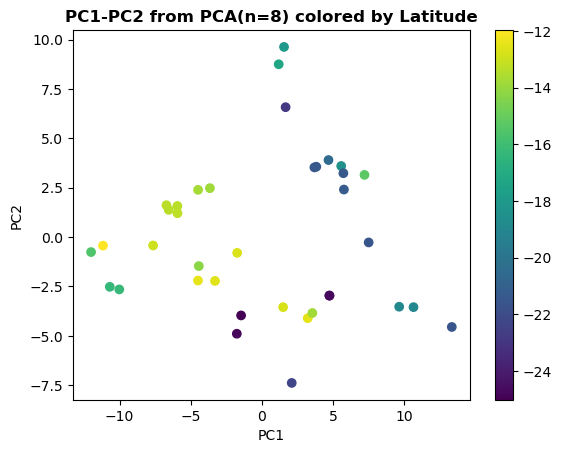

In [ ]:
# Plot the first 2 dimension for visualization purposes
plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gdf_gbs["Latitude"])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC1-PC2 from PCA(n=8) colored by Latitude", weight="bold")
plt.colorbar()

In [ ]:
# t-SNE viz with 2 compo
tsne = TSNE(random_state=0)
X_tsne = tsne.fit_transform(X_pca)

plt.figure()
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=gdf_gbs["Latitude"])
plt.xlabel("dim1")
plt.ylabel("dim2")
plt.colorbar()
plt.title("t-SNE projection from PCA(n=8) colored by Latitude", weight="bold")

Text(0.5, 1.0, 't-SNE projection from PCA(n=8) colored by Latitude')

### Clustering

#### K-means
Using the 8PC-reduced data, let's determine the number of K clusters

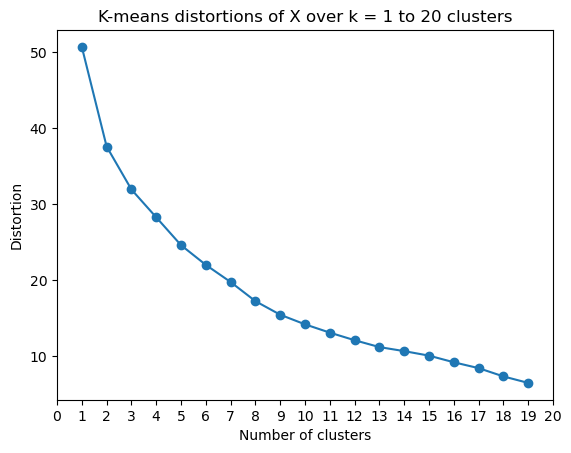

[50.644570790717864,
 37.54383967105194,
 31.89123736997579,
 28.23351215462066,
 24.567994664436302,
 21.975277391717874,
 19.720563633231478,
 17.203226576961047,
 15.417544458933591,
 14.154406587907213,
 13.063774953177159,
 12.065734638080114,
 11.162486939497317,
 10.631107088662807,
 10.037392579538887,
 9.164953078130873,
 8.394702844450633,
 7.304844074646544,
 6.449542508482596]

In [ ]:
# Elbow method
def elbow_method(X, min_clusters, max_clusters):
    # Kmeans for each min/max clusters
    distortions = []
    for i in range(min_clusters, max_clusters):
        km = KMeans(n_clusters=i, n_init=10).fit(X)
        distortions.append(np.sqrt(km.inertia_))
    # Plot distortions
    fig = plt.figure()
    
    plt.plot(range(min_clusters,len(distortions)+min_clusters), distortions, marker="o")
    plt.title(
        f"K-means distortions of {list(locals().keys())[0]} over k = {min_clusters} to {max_clusters} clusters"
    )
    plt.xlabel("Number of clusters")
    plt.xticks(range(min_clusters-1, max_clusters+1))
    plt.ylabel("Distortion")
    plt.show()
    
    return distortions

elbow_method(X_pca, 1, 20)

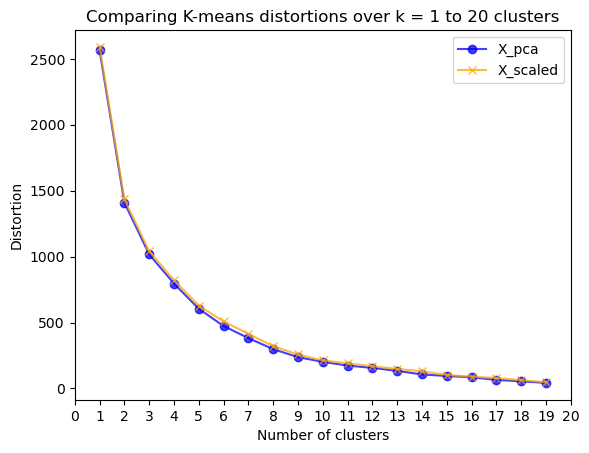

In [ ]:
# Comparing non-PCA vs 8PC
distos_pca = []
distos_scaled = []
min_clusters = 1
max_clusters = 20

for i in range(min_clusters, max_clusters):
    km_pca = KMeans(n_clusters=i, n_init=10).fit(X_pca)
    km_scaled = KMeans(n_clusters=i, n_init=10).fit(X_scaled)
    distos_pca.append(km_pca.inertia_)
    distos_scaled.append(km_scaled.inertia_)
# Plot distos_pca
fig = plt.figure()

plt.plot(range(min_clusters,len(distos_pca)+min_clusters), distos_pca, marker="o", c="blue", alpha=0.75)
plt.plot(range(min_clusters,len(distos_scaled)+min_clusters), distos_scaled, marker="x", c="orange", alpha=0.75)
plt.title(f"Comparing K-means distortions over k = {min_clusters} to {max_clusters} clusters")
plt.xlabel("Number of clusters")
plt.xticks(range(min_clusters-1, max_clusters+1))
plt.ylabel("Distortion")
plt.legend(["X_pca", "X_scaled"])
plt.show()

Not very clear, let's use the Silhouette score

For k = 2, silouhette avg = 0.3866288692181401
For k = 3, silouhette avg = 0.38019905183804126
For k = 4, silouhette avg = 0.34820543548157334
For k = 5, silouhette avg = 0.3966376486115509
For k = 6, silouhette avg = 0.43380921124946137
For k = 7, silouhette avg = 0.44694777088956134
For k = 8, silouhette avg = 0.4613861281822642
For k = 9, silouhette avg = 0.4803882129669264
For k = 10, silouhette avg = 0.47369764681194976
For k = 11, silouhette avg = 0.5022657047285667
For k = 12, silouhette avg = 0.48191179023293335
For k = 13, silouhette avg = 0.4861448808124455
For k = 14, silouhette avg = 0.46904024756612506
For k = 15, silouhette avg = 0.4565585349642577


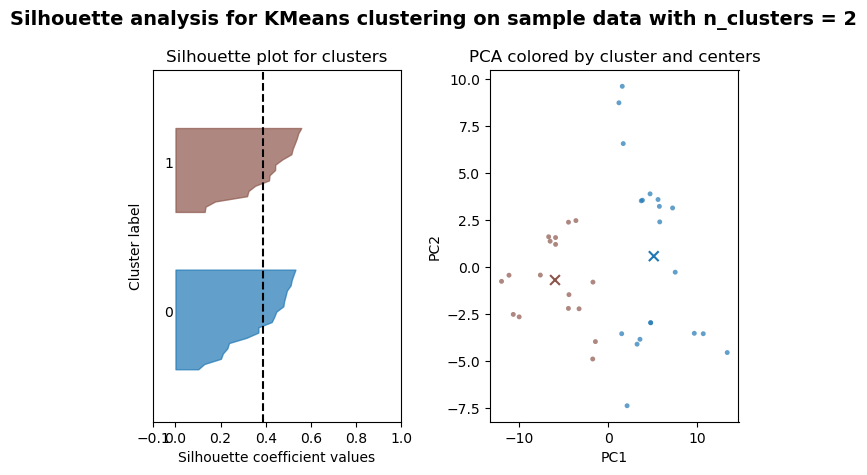

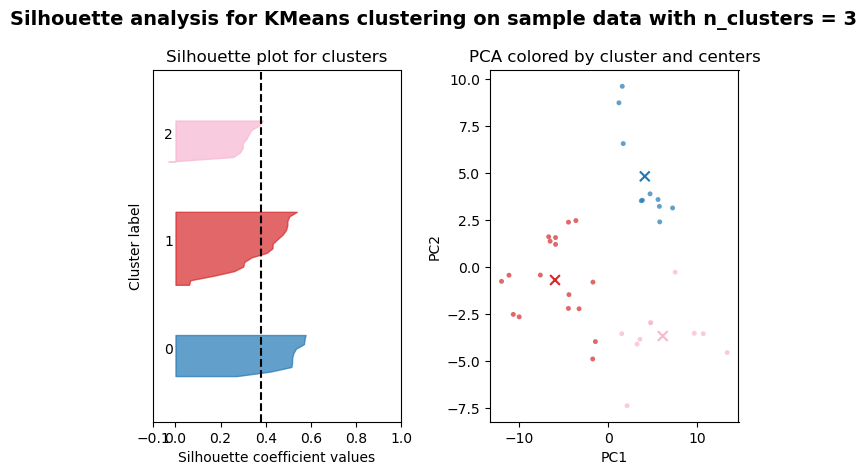

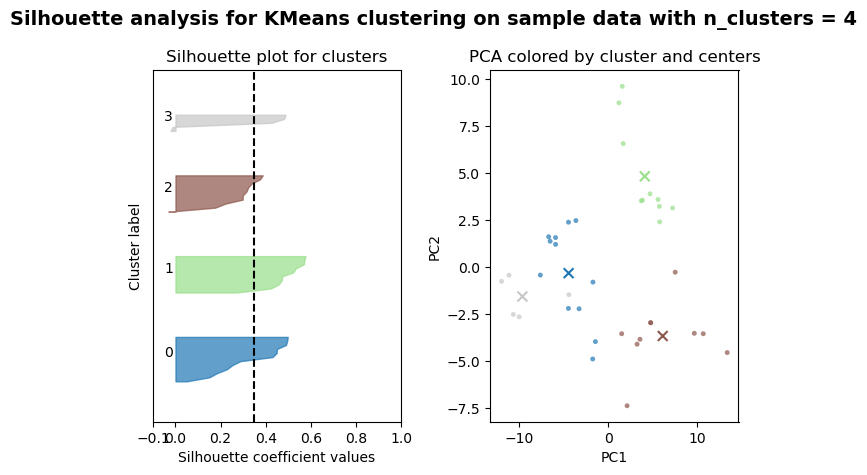

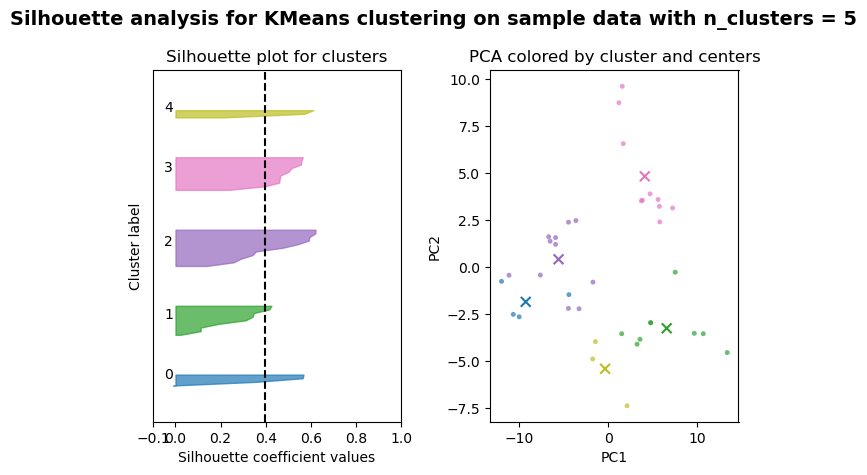

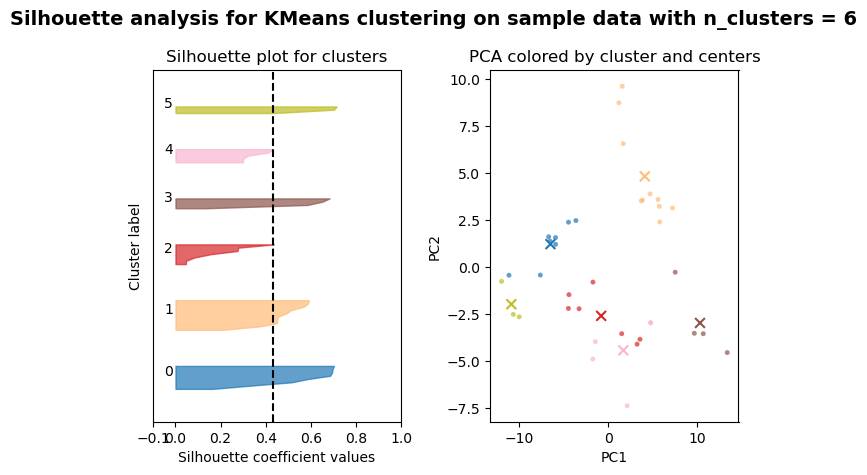

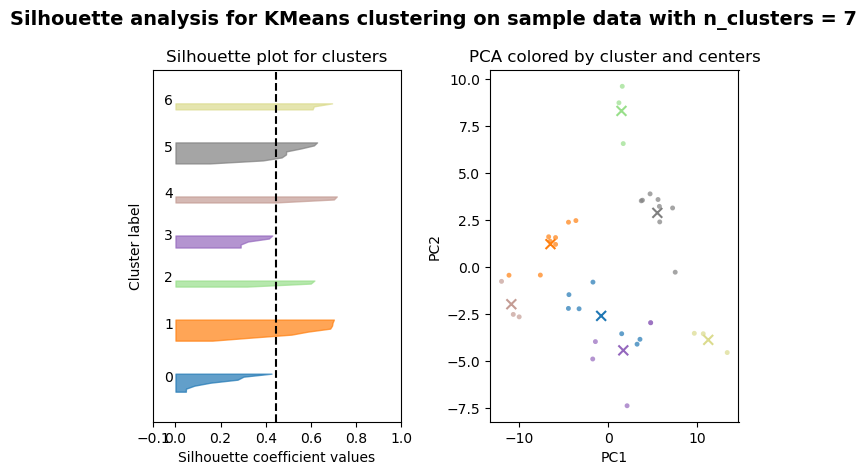

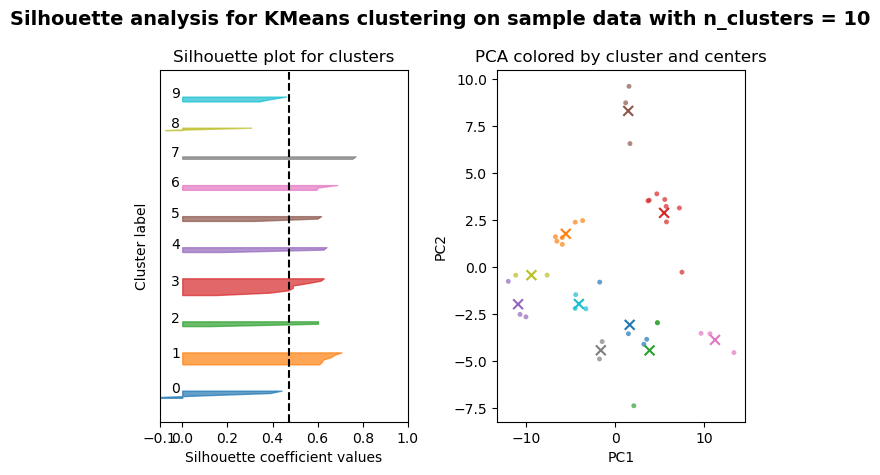

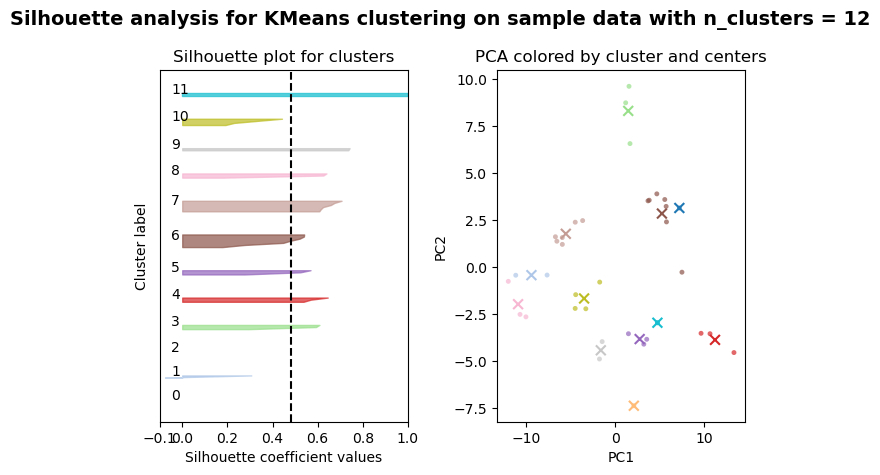

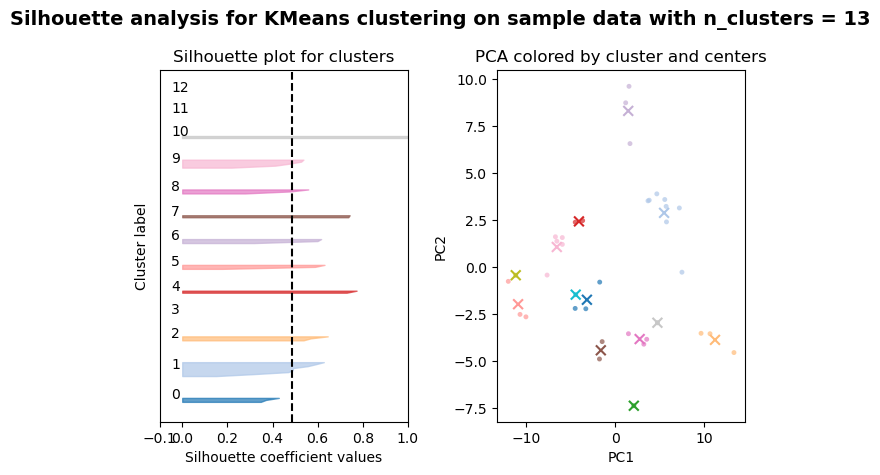

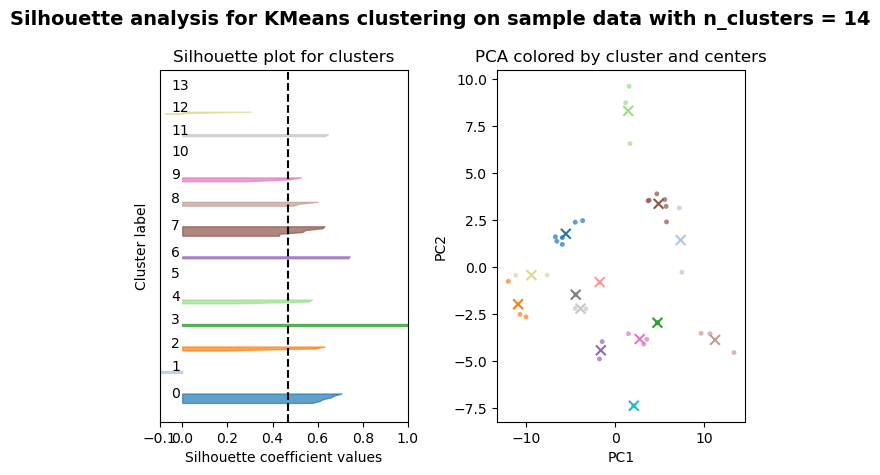

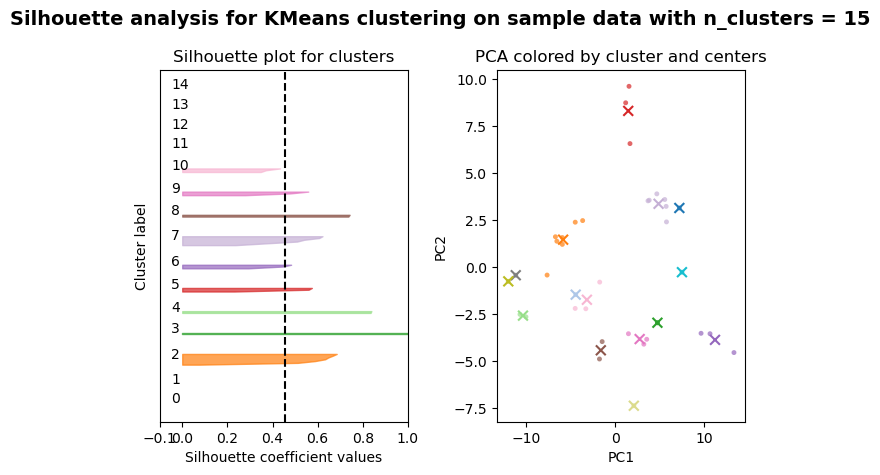

In [ ]:
# Inspired by sklearn docs
def silouhette_plot(X, min_clusters, max_clusters):
    range_n_clusters = list(range(min_clusters, max_clusters+1))
    # label_colors = [plt.cm.tab20(i) for i in range_n_clusters]
    
    for n_clusters in range_n_clusters:
        # Set fig params
        fig, (ax1, ax2) = plt.subplots(1,2)
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
        
        # KMeans + silouhette avg
        km = KMeans(n_clusters=n_clusters, n_init=10).fit(X)
        silhouette_avg = silhouette_score(X, km.labels_)
        print(f"For k = {n_clusters}, silouhette avg = {silhouette_avg}")
        
        # Silouhette scores for each samples
        sample_silouhette_vals = silhouette_samples(X, km.labels_)
        y_lower = 10
        
        for i in range(n_clusters):
            # Sort sil scores per sample
            ith_cluster_silhouette_values = sample_silouhette_vals[km.labels_ == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            label_color = plt.cm.tab20(i / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=label_color,
                edgecolor=label_color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("Silhouette plot for clusters")
        ax1.set_xlabel("Silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="black", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # Plot PCA
        pca = PCA(n_components=2).fit(X)
        data2d = pca.transform(X)
        cluster_colors = plt.cm.tab20(km.labels_.astype(float) / n_clusters)
        ax2.scatter(
            data2d[:,0], data2d[:,1], marker=".", s=50, lw=0, c=cluster_colors, alpha=0.7, edgecolor="k"
        )
        
        # Labeling the clusters
        centers2d = pca.transform(km.cluster_centers_)
        centers_colors = plt.cm.tab20(np.unique(km.labels_.astype(float) / n_clusters))
        ax2.scatter(centers2d[:, 0], centers2d[:, 1], marker="x", c=centers_colors, s=50)

        ax2.set_title("PCA colored by cluster and centers")
        ax2.set_xlabel("PC1")
        ax2.set_ylabel("PC2")

        plt.suptitle(
            f"Silhouette analysis for KMeans clustering on sample data with n_clusters = {n_clusters}",
            fontsize=14,
            fontweight="bold",
        )
        fig.tight_layout()

    plt.show()
    
silouhette_plot(X_scaled, 2, 15)

With 8PCs-reduced data

For k = 2, silouhette avg = 0.391926362480854
For k = 3, silouhette avg = 0.39235620066652926
For k = 4, silouhette avg = 0.35688544469053024
For k = 5, silouhette avg = 0.4070884167612492
For k = 6, silouhette avg = 0.43812710005580446
For k = 7, silouhette avg = 0.44758239647762177
For k = 8, silouhette avg = 0.4668555767115038
For k = 9, silouhette avg = 0.5099277329796472
For k = 10, silouhette avg = 0.5205113139477354


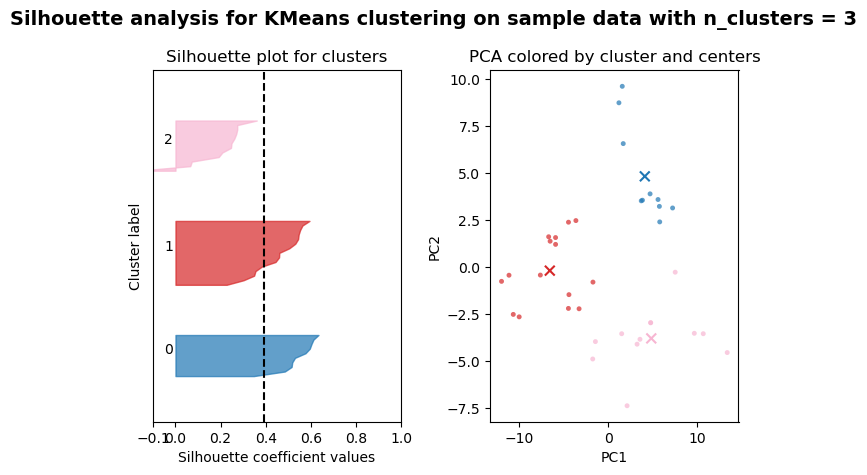

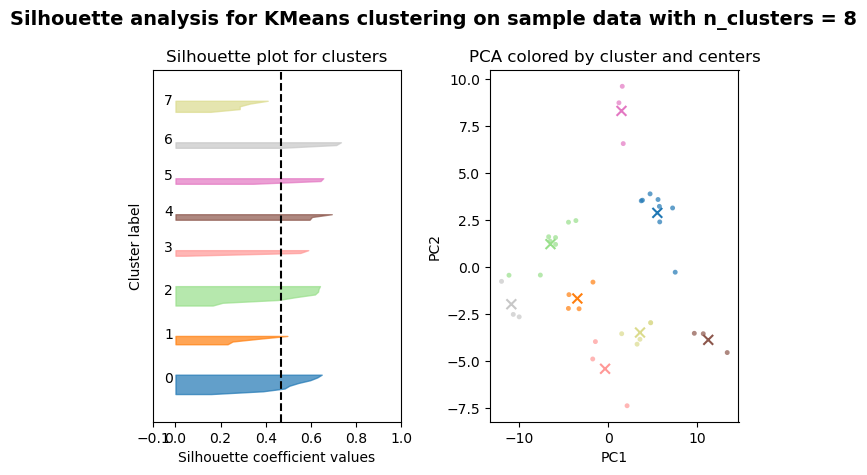

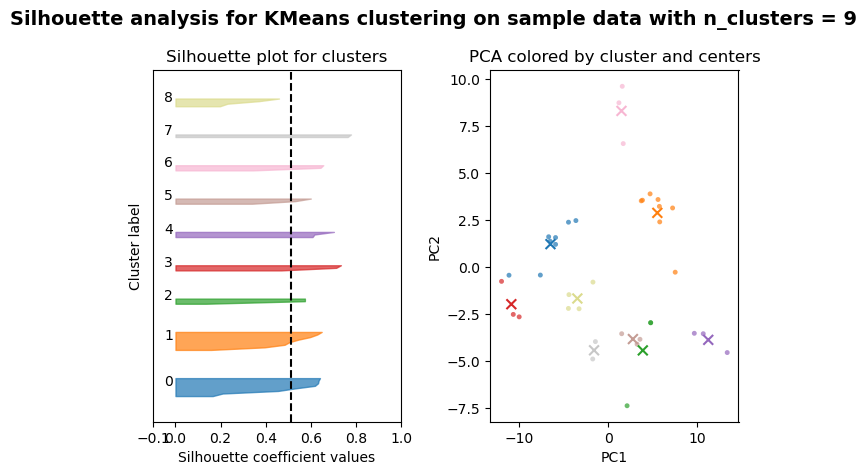

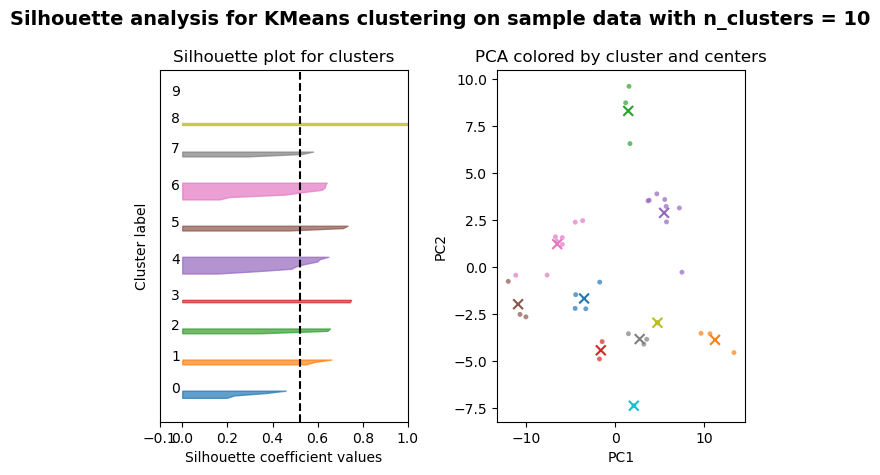

In [ ]:
silouhette_plot(X_pca, 2, 10)

Picking 5 to 8 clusters based on Silhouette score and PCA cluster overlap with 8PCs-reduced data

In [ ]:
# Fitting the model for 5 to 8 PCs
km_pca = KMeans(n_clusters=5, n_init=10).fit(X_pca)


In [ ]:
gdf_gbs["cluster"] = km_pca.labels_

In [ ]:
list(set(km_pca.labels_))

[0, 1, 2, 3, 4]

In [ ]:
# Wrap the kmeans clustering + map plotting together
def kmeans_map_plot(X, min_k, max_k, layer_num, gdf):
    if min_k > max_k:
        raise ValueError("min_k must be smaller than max_k")
    if min_k == 0:
        raise ValueError("Provide a K greater than 0")
    
    # Setup subplots with 2 cols always
    if min_k % 2 != 0 and max_k % 2 != 0:
        nrows = int((max_k - min_k) / 2 + 1)
    elif min_k % 2 == 0 and max_k % 2 == 0:
        nrows = int((max_k - min_k) / 2 + 1)
    else : 
        nrows = int((max_k - min_k + 1) / 2)
    
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(5*nrows, 15))
    axes = axes.ravel()
    layer = mada_layers[f"layer{layer_num}"]
    
    # Open raster and fit kmeans for each k
    with rasterio.open(CLIMATE_DIR / MADACLIM_CURRENT_TIF) as raster_mada:
        for i, k in enumerate(range(min_k, max_k+1)):
            # Fit the model and get clusters
            km = KMeans(n_clusters=k, n_init=10).fit(X)
                            
            axes[i] = rasterio.plot.show(
                    raster_mada.read(layer_num, masked=True),
                    transform=raster_mada.transform,
                    alpha=0.5,
                    cmap="Greys", 
                    ax=axes[i], 
                    title=f"layer{layer_num} : {layer} \nand K-Means with k={k} clusters",
                )
            # cax = plt.axes([0.85, 0.1, 0.075, 0.8])  #! DEPRECATED OPTIOSN
            # norm = colors.Normalize(vmin=gdf_gbs["cluster"].min(), vmax=gdf_gbs["cluster"].max())
            # cb = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
            # cbar = fig.colorbar(cb, cax=cax)
            # cbar.ax.set_yticklabels(gdf_gbs["cluster"].unique())
            
            # Get qualititavte color map according to k
            cmap = colors.ListedColormap(
                    plt.cm.get_cmap("Set1").colors[:k]
                    )

            # Get labels from each km-iteration 
            gdf["cluster"] = km.labels_
            
            gdf.plot(
                ax=axes[i], 
                column="cluster",
                c=km.labels_,
                cmap=cmap,
                markersize=15, 
                legend=True, 
                legend_kwds={
                    "spacing" : "uniform", 
                    # "cax" : cax, #! DEPRECATED ALT COLORBAR
                    "ticklocation" : "left",
                    "ticks" : range(k), #* KCLUST
                    "extend" : "both",
                }
                
            )
    fig.tight_layout()
    
    # Reset cluster labels
    gdf = gdf.drop(columns=["cluster"])
    
    # return gdf
            

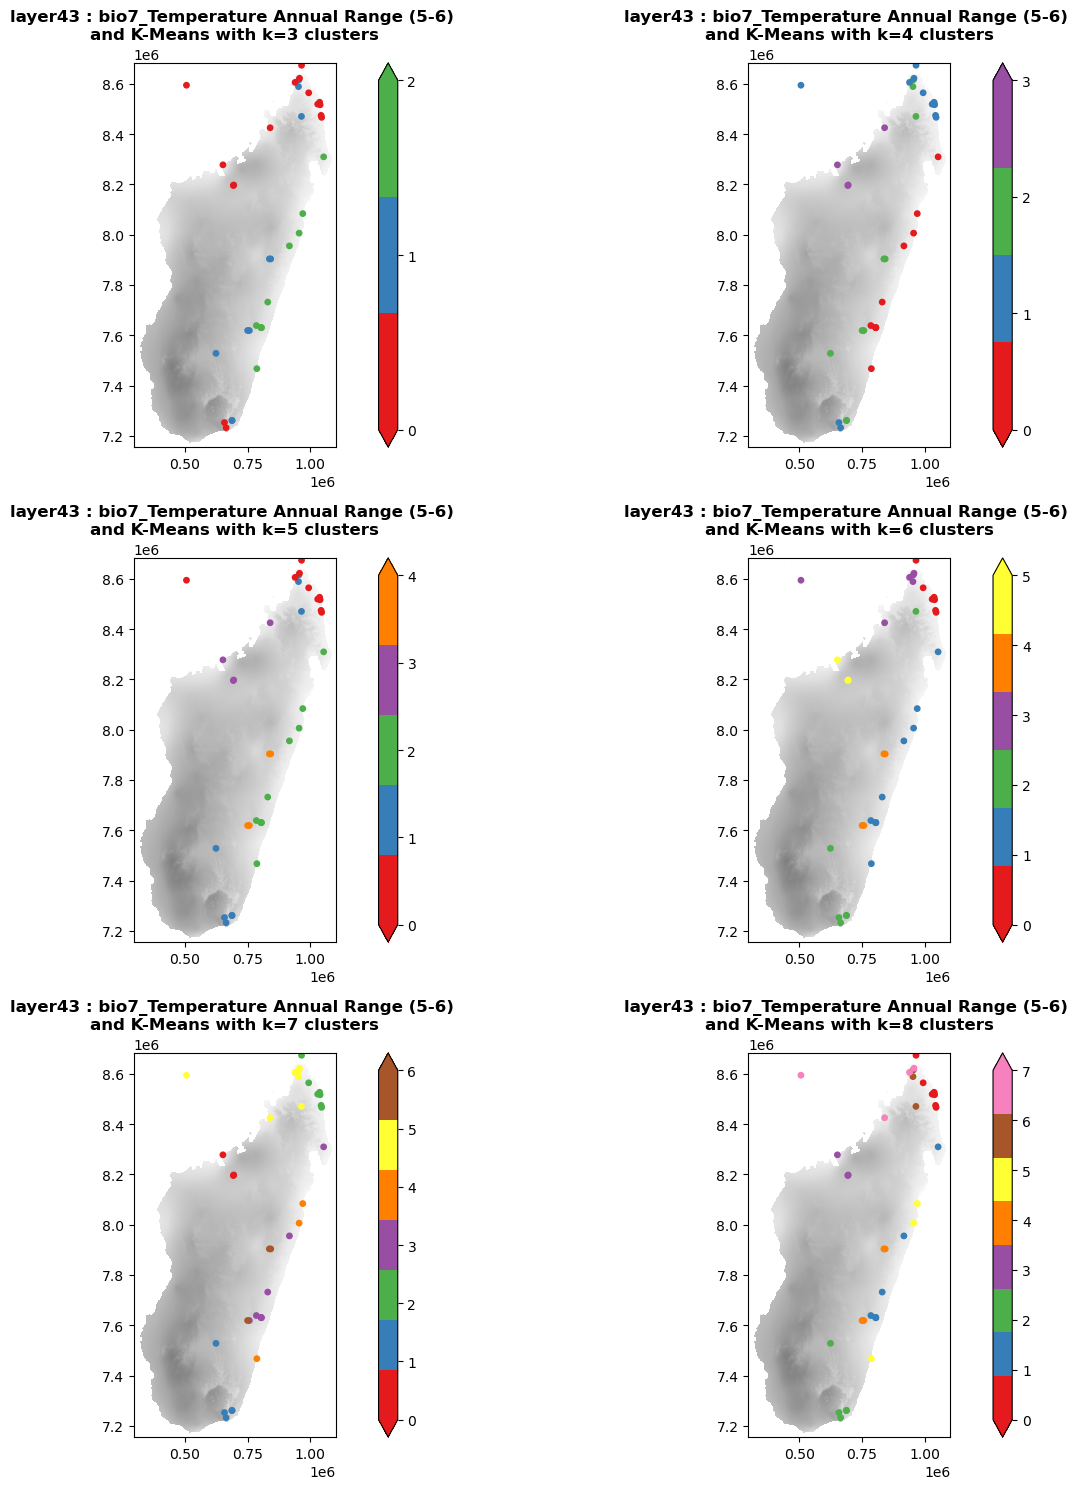

In [ ]:
# Scaled data
kmeans_map_plot(X_scaled, 3, 8, 43, gdf_gbs)

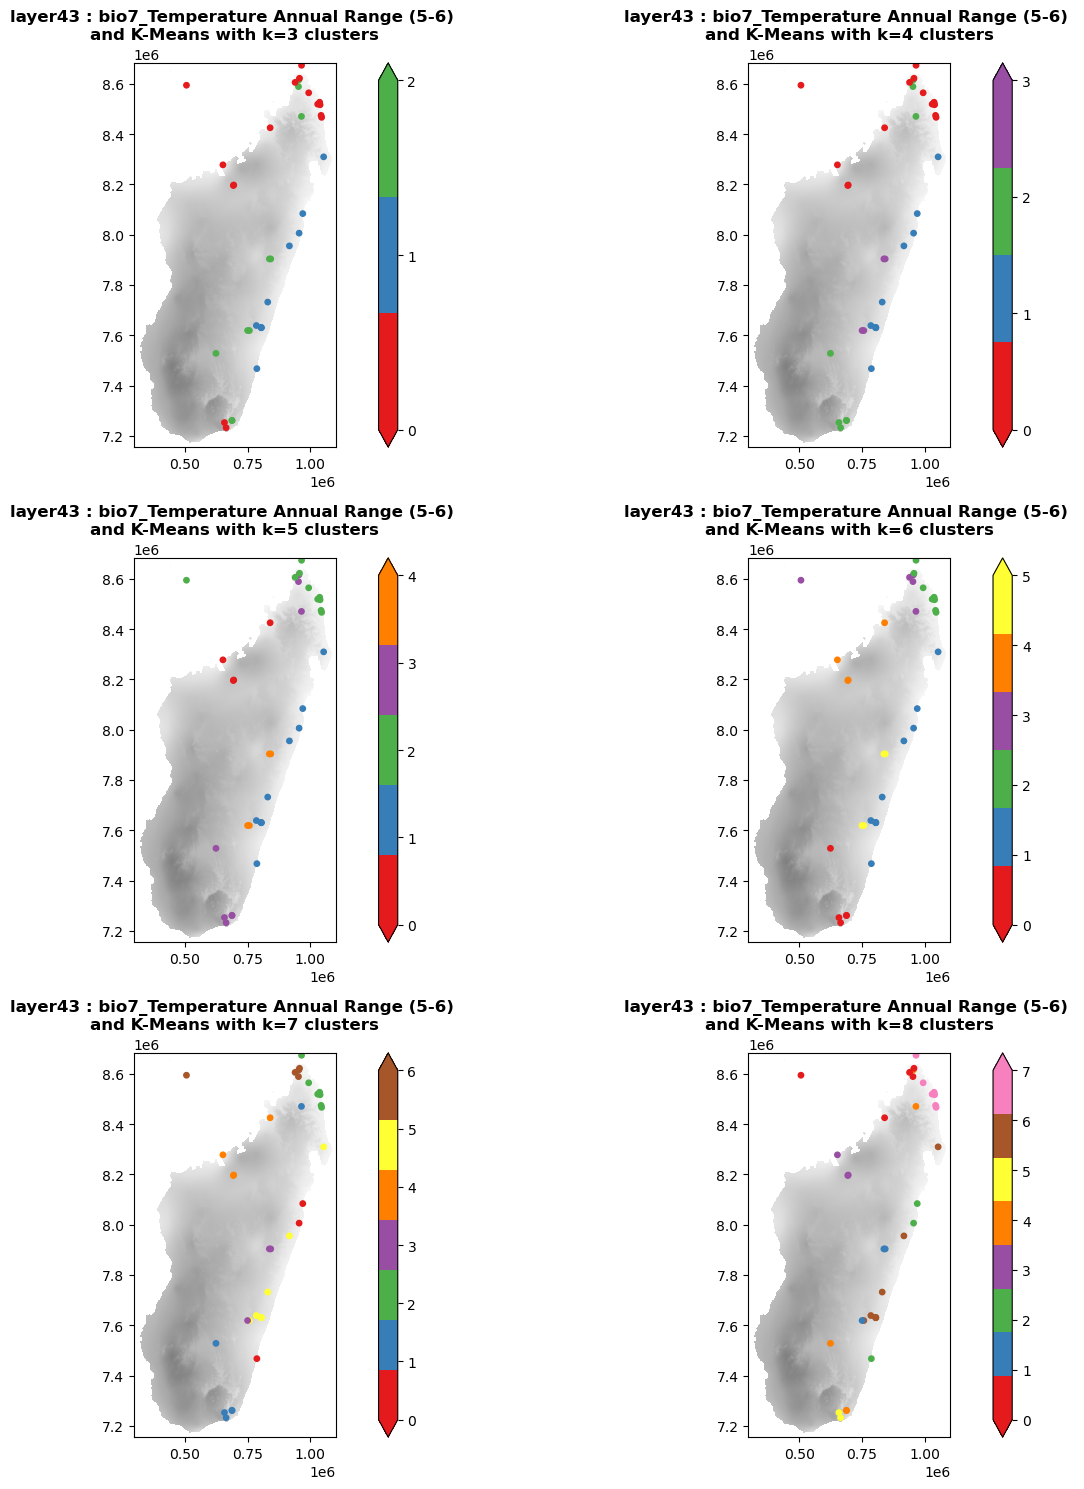

In [ ]:
kmeans_map_plot(X_pca, 3, 8, 43, gdf_gbs)

In [ ]:
# To validate on the previous map the colors of the clusters
gdf_gbs[["geometry","cluster", "Latitude"]].sort_values(by="Latitude").head(10)

geometry  cluster  Latitude
Species code                                                   
BERT          POINT (664808.037 7232213.963)        5 -25.01666
PER1          POINT (658169.137 7252603.015)        5 -24.83330
ABA           POINT (688328.240 7260998.023)        4 -24.75410
KIA2          POINT (688338.355 7260997.885)        4 -24.75410
FAR           POINT (787281.628 7467033.374)        2 -22.88000
SAK           POINT (624595.051 7527931.783)        4 -22.35000
MIL2          POINT (750334.648 7618740.006)        1 -21.51660
LAN           POINT (757247.218 7618631.529)        6 -21.51660
MON           POINT (805036.157 7629647.965)        6 -21.40970
AND2          POINT (805033.840 7630631.025)        6 -21.40083